## 1. Processas e preparar a base de dados

## 1.1. Instalar as bibliotecas necessárias

In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import math
from scipy.stats import zscore, ttest_ind, f_oneway, chi2_contingency
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay

## 1.2. Importar os arquivos no notebook

In [206]:
# Carregar arquivos excel

dot_dict = pd.read_excel("../dataset/DOT_CODE_DICTIONARY.xlsx")
flights = pd.read_csv("../dataset/flights_202301.csv")
airline_dict = pd.read_csv("../dataset/AIRLINE_CODE_DICTIONARY.csv")

In [207]:
# conferir 

print(f"Shape of Voos: {flights.shape}")
print(f"Shape of Airline_dict: {airline_dict.shape}")
print(f"Shape of Dot_dict: {dot_dict.shape}")

Shape of Voos: (538837, 33)
Shape of Airline_dict: (1729, 2)
Shape of Dot_dict: (1737, 2)


## 1.3. Conferir informações iniciais

In [208]:
# Ajustar nomes das colunas
airline_dict = airline_dict.rename(
    columns=lambda col: f"AIRLINE_{col}" if col != "Code" else col
)
dot_dict = dot_dict.rename(
    columns=lambda col: f"DOT_{col}" if col != "Code" else col
)

In [209]:
airline_dict = airline_dict.rename(
    columns={"AIRLINE_AIRLINE_AIRLINE_{col}": "AIRLINE_Description"}
)

dot_dict = dot_dict.rename(
    columns={"DOT_{col}": "DOT_Description"}
)

In [210]:
# Ver dimensões
print("Voos:", flights.shape)
print("Airline dict:", airline_dict.shape)
print("DOT dict:", dot_dict.shape)

Voos: (538837, 33)
Airline dict: (1729, 2)
DOT dict: (1737, 2)


In [211]:
pd.set_option("display.max_rows", None)

# Resumo das colunas
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538837 entries, 0 to 538836
Data columns (total 33 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   FL_DATE                  538837 non-null  object 
 1   AIRLINE_CODE             538837 non-null  object 
 2   DOT_CODE                 538837 non-null  int64  
 3   FL_NUMBER                538837 non-null  int64  
 4   ORIGIN                   538837 non-null  object 
 5   ORIGIN_CITY              538837 non-null  object 
 6   DEST                     538837 non-null  object 
 7   DEST_CITY                538837 non-null  object 
 8   CRS_DEP_TIME             538837 non-null  int64  
 9   DEP_TIME                 528859 non-null  float64
 10  DEP_DELAY                528855 non-null  float64
 11  TAXI_OUT                 528640 non-null  float64
 12  WHEELS_OFF               528640 non-null  float64
 13  WHEELS_ON                528318 non-null  float64
 14  TAXI

In [212]:
flights.drop(['FL_MONTH', 'FL_YEAR'], axis=1, inplace=True)

In [213]:
airline_dict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1729 entries, 0 to 1728
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Code                 1728 non-null   object
 1   AIRLINE_Description  1729 non-null   object
dtypes: object(2)
memory usage: 27.1+ KB


In [214]:
dot_dict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1737 entries, 0 to 1736
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Code             1737 non-null   int64 
 1   DOT_Description  1733 non-null   object
dtypes: int64(1), object(1)
memory usage: 27.3+ KB


## 1.4. Ajustar tipo de dados

1.4.1 Flights

In [215]:
flights_optimized = flights.copy()

In [216]:
# Converte em Data

flights_optimized["FL_DATE"] = pd.to_datetime(
    flights_optimized["FL_DATE"].astype(str),
    format="%Y-%m-%d",
    errors='coerce'
)

flights_optimized["FL_DAY"] = flights_optimized["FL_DATE"] .dt.day.astype('float32')

In [217]:
# 2. Converter para categóricas

cols_category = [
    "AIRLINE_CODE", "ORIGIN", "ORIGIN_CITY", "DEST", "DEST_CITY", "CANCELLATION_CODE"
]
for col in cols_category:
    flights_optimized[col] = flights_optimized[col].astype("category")
## para cada coluna da lista, se ela existir, converte para category, pois reduz o uso da memória e acelera operações
### os valores permanecem como texto, mas internamente são armazenados como códigos inteiros + mapeamento 

In [218]:
# 3. Converter variáveis booleanas

flights_optimized["CANCELLED"] = flights_optimized["CANCELLED"].astype("bool")
flights_optimized["DIVERTED"] = flights_optimized["DIVERTED"].astype("bool")
## os NA são presercados ao utilizadas .astype("boolean")


In [219]:
# 4. Ajustar a conversão de tempo e todas as colunas de tempo

# Converter colunas de horários (HHMM) para int, ignorando erros

time_cols = ["DEP_TIME", "ARR_TIME", "CRS_DEP_TIME", "CRS_ARR_TIME", "AIR_TIME", "WHEELS_OFF", "WHEELS_ON"]
for col in time_cols:
    if col in flights_optimized.columns:
        flights_optimized[col] = pd.to_numeric(flights_optimized[col], errors="coerce")

In [220]:
# Converter atrasos e tempos para numérico
num_cols = ["TAXI_IN", "TAXI_OUT", "ELAPSED_TIME", "DEP_DELAY", "ARR_DELAY"]
for col in num_cols:
    if col in flights_optimized.columns:
        flights_optimized[col] = pd.to_numeric(flights_optimized[col], errors="coerce")

In [221]:
# 5. Converter colunas numéricas inteiras

int_columns_small = ["FL_NUMBER", "DOT_CODE"]
for col in int_columns_small:
    if col in flights_optimized.columns:
        max_val = flights_optimized[col].max()
        if max_val <= 32767:  # int16
            flights_optimized[col] = flights_optimized[col].astype("int16")
        elif max_val <= 2147483647:  # int32
            flights_optimized[col] = flights_optimized[col].astype("int32")

# 'Distance' can likely be int16 (max ~32k miles)
if "DISTANCE" in flights_optimized.columns:
    flights_optimized["DISTANCE"] = flights_optimized["DISTANCE"].astype("int16")

# Convert to float32 (saves 50% memory vs float64)
float_columns = [
    "DEP_DELAY", "TAXI_OUT", "TAXI_IN", "ARR_DELAY",
    "CRS_ELAPSED_TIME", "ELAPSED_TIME", "AIR_TIME",
    "DELAY_DUE_CARRIER", "DELAY_DUE_WEATHER", "DELAY_DUE_NAS",
    "DELAY_DUE_SECURITY", "DELAY_DUE_LATE_AIRCRAFT"
]
for col in float_columns:
    if col in flights_optimized.columns:
        flights_optimized[col] = pd.to_numeric(flights_optimized[col], errors='coerce')
        flights_optimized[col] = flights_optimized[col].astype("float32")


In [222]:
# Verificar resultado
flights_optimized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538837 entries, 0 to 538836
Data columns (total 31 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   FL_DATE                  538837 non-null  datetime64[ns]
 1   AIRLINE_CODE             538837 non-null  category      
 2   DOT_CODE                 538837 non-null  int16         
 3   FL_NUMBER                538837 non-null  int16         
 4   ORIGIN                   538837 non-null  category      
 5   ORIGIN_CITY              538837 non-null  category      
 6   DEST                     538837 non-null  category      
 7   DEST_CITY                538837 non-null  category      
 8   CRS_DEP_TIME             538837 non-null  int64         
 9   DEP_TIME                 528859 non-null  float64       
 10  DEP_DELAY                528855 non-null  float32       
 11  TAXI_OUT                 528640 non-null  float32       
 12  WHEELS_OFF      

1.4.2. airline_dict

In [223]:
df_airline_optimized = airline_dict.copy()

df_airline_optimized['Code'] = df_airline_optimized['Code'].astype('category')

# 2. Convert 'AIRLINE_Description' to category
df_airline_optimized['AIRLINE_Description'] = df_airline_optimized['AIRLINE_Description'].astype('category')

In [224]:
df_airline_optimized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1729 entries, 0 to 1728
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Code                 1728 non-null   category
 1   AIRLINE_Description  1729 non-null   category
dtypes: category(2)
memory usage: 163.0 KB


1.4.3. dot_dict

In [225]:
df_dot_optimized = dot_dict.copy()

In [226]:
# 1. Converter dado numérico
df_dot_optimized['Code'] = pd.to_numeric(df_dot_optimized['Code'], errors='coerce')

max_dot_code = df_dot_optimized['Code'].max()

if max_dot_code <= 32767:  
    df_dot_optimized['Code'] = df_dot_optimized['Code'].astype('int16')
elif max_dot_code <= 2147483647: 
    df_dot_optimized['Code'] = df_dot_optimized['Code'].astype('int32')

# 2. Convert 'DOT_Description' to category
df_dot_optimized['DOT_Description'] = df_dot_optimized['DOT_Description'].astype('category')

# 3. Remove the redundant part after ':'
df_dot_optimized["DOT_Description"] = df_dot_optimized["DOT_Description"].str.split(":").str[0].str.strip()

In [227]:
df_dot_optimized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1737 entries, 0 to 1736
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Code             1737 non-null   int16 
 1   DOT_Description  1733 non-null   object
dtypes: int16(1), object(1)
memory usage: 17.1+ KB


## 1.5. Unir Tabelas

Análise das variáveis AIRLINE_CODE e DOT_CODE na tabela flights

In [228]:
flights_optimized["AIRLINE_CODE"].unique()

['9E', 'AA', 'AS', 'B6', 'DL', ..., 'WN', 'YX', 'OH', 'OO', 'UA']
Length: 15
Categories (15, object): ['9E', 'AA', 'AS', 'B6', ..., 'OO', 'UA', 'WN', 'YX']

In [229]:
flights_optimized["DOT_CODE"].unique()

array([20363, 19805, 19930, 20409, 19790, 20436, 20368, 19690, 20398,
       20416, 19393, 20452, 20397, 20304, 19977], dtype=int16)

In [230]:
# Merge com a tabela de voos
df_dot_optimized = df_dot_optimized.rename(columns={"Code": "DOT_CODE"})

df = pd.merge(
    flights_optimized,
    df_dot_optimized,
    on="DOT_CODE",
    how="left"
)

df_airline_optimized = df_airline_optimized.rename(columns={"Code": "AIRLINE_CODE"})
df = pd.merge(
    df,
    df_airline_optimized,
    on="AIRLINE_CODE",
    how="left"
)

## 1.6. Identificar e tratar valores nulos

In [231]:
df.isnull().sum()

FL_DATE                         0
AIRLINE_CODE                    0
DOT_CODE                        0
FL_NUMBER                       0
ORIGIN                          0
ORIGIN_CITY                     0
DEST                            0
DEST_CITY                       0
CRS_DEP_TIME                    0
DEP_TIME                     9978
DEP_DELAY                    9982
TAXI_OUT                    10197
WHEELS_OFF                  10197
WHEELS_ON                   10519
TAXI_IN                     10519
CRS_ARR_TIME                    0
ARR_TIME                    10519
ARR_DELAY                   11640
CANCELLED                       0
CANCELLATION_CODE               0
DIVERTED                        0
CRS_ELAPSED_TIME                1
ELAPSED_TIME                11640
AIR_TIME                    11640
DISTANCE                        0
DELAY_DUE_CARRIER          422124
DELAY_DUE_WEATHER          422124
DELAY_DUE_NAS              422124
DELAY_DUE_SECURITY         422124
DELAY_DUE_LATE

In [232]:
def checkMissing(data,perc=0):
    missing = [(i, data[i].isna().mean()*100) for i in data]
    missing = pd.DataFrame(missing, columns=["column_name", "percentage"])
    missing = missing[missing.percentage > perc]
    print(missing.sort_values("percentage", ascending=False).reset_index(drop=True))

print("Proportion of missing data in columns")
checkMissing(df)

Proportion of missing data in columns
                column_name  percentage
0         DELAY_DUE_WEATHER   78.339832
1             DELAY_DUE_NAS   78.339832
2        DELAY_DUE_SECURITY   78.339832
3   DELAY_DUE_LATE_AIRCRAFT   78.339832
4         DELAY_DUE_CARRIER   78.339832
5                 ARR_DELAY    2.160208
6              ELAPSED_TIME    2.160208
7                  AIR_TIME    2.160208
8                   TAXI_IN    1.952167
9                 WHEELS_ON    1.952167
10                 ARR_TIME    1.952167
11                 TAXI_OUT    1.892409
12               WHEELS_OFF    1.892409
13                DEP_DELAY    1.852508
14                 DEP_TIME    1.851766
15         CRS_ELAPSED_TIME    0.000186


In [233]:
# Removing null in CRS_ELAPSED_TIME (1)
df = df.dropna(subset=["CRS_ELAPSED_TIME"])

In [234]:
# Checkin about the DELAYS in CANCELLED and DIVERTED
delay_cols = [
    "DELAY_DUE_CARRIER",
    "DELAY_DUE_WEATHER",
    "DELAY_DUE_NAS",
    "DELAY_DUE_SECURITY",
    "DELAY_DUE_LATE_AIRCRAFT"
]

# Filtrar linhas com atraso nulo
df_null_delays = df[df[delay_cols].isna().any(axis=1)]

# Separar normal vs cancelado/desviado
delay_flag_0 = df_null_delays[(df_null_delays["CANCELLED"] == 0) & (df_null_delays["DIVERTED"] == 0)]
delay_flag_1 = df_null_delays[(df_null_delays["CANCELLED"] == 1) | (df_null_delays["DIVERTED"] == 1)]

total_rows = len(df)
prop_delay_flag_0 = len(delay_flag_0) / total_rows * 100
prop_delay_flag_1 = len(delay_flag_1) / total_rows * 100

print(f"\nTotal de dados: {total_rows:,}")
print(f"Delay nulo em voo normal: {len(delay_flag_0):,} ({prop_delay_flag_0:.2f}%)")
print(f"Delay nulo em voo cancelado/desviado: {len(delay_flag_1):,} ({prop_delay_flag_1:.2f}%)")

dist = delay_flag_1[["CANCELLED", "DIVERTED"]].value_counts()
dist_prop = dist / total_rows * 100

print("\nDistribuição entre CANCELLED e DIVERTED (valores absolutos e % do total):")
print(pd.concat([dist, dist_prop.rename("proporção %")], axis=1))

# Linhas canceladas/desviadas onde TODOS os 5 delays estão nulos
all_delay_null = delay_flag_1[delay_flag_1[delay_cols].isna().all(axis=1)]

print(f"\nLinhas canceladas/desviadas com TODOS os 5 delays nulos: {len(all_delay_null):,}")
print(f"Proporção no total do banco: {len(all_delay_null) / total_rows * 100:.2f}%")


Total de dados: 538,836
Delay nulo em voo normal: 410,484 (76.18%)
Delay nulo em voo cancelado/desviado: 11,639 (2.16%)

Distribuição entre CANCELLED e DIVERTED (valores absolutos e % do total):
                    count  proporção %
CANCELLED DIVERTED                    
True      False     10294     1.910414
False     True       1345     0.249612

Linhas canceladas/desviadas com TODOS os 5 delays nulos: 11,639
Proporção no total do banco: 2.16%


In [235]:
df.loc[df['CANCELLED'] == 0, delay_cols] = df.loc[df['CANCELLED'] == 0, delay_cols].fillna(0)

In [236]:
print("Proportion of missing data in columns")
checkMissing(df)

Proportion of missing data in columns
                column_name  percentage
0                  AIR_TIME    2.160026
1              ELAPSED_TIME    2.160026
2                 ARR_DELAY    2.160026
3                   TAXI_IN    1.951985
4                  ARR_TIME    1.951985
5                 WHEELS_ON    1.951985
6         DELAY_DUE_CARRIER    1.910414
7         DELAY_DUE_WEATHER    1.910414
8             DELAY_DUE_NAS    1.910414
9        DELAY_DUE_SECURITY    1.910414
10  DELAY_DUE_LATE_AIRCRAFT    1.910414
11               WHEELS_OFF    1.892227
12                 TAXI_OUT    1.892227
13                DEP_DELAY    1.852326
14                 DEP_TIME    1.851584


## 1.7. Identificar e Tratar valores duplicados

7.1. Identificando os valores duplicados

In [237]:
df.duplicated().any()

np.False_

## 1.8. Identificar e Tratar Dados Fora do Escopo de Análise

In [238]:
# Contagem de voos cancelados e desviados",
print("Códigos de cancelamento inválidos:")
print(df["CANCELLATION_CODE"].unique())

Códigos de cancelamento inválidos:
['Z', 'C', 'B', 'D', 'A']
Categories (5, object): ['A', 'B', 'C', 'D', 'Z']


In [239]:
contagem = df[df['CANCELLATION_CODE'] == 'A'].shape[0]
print("Número de clientes com código A:", contagem)

contagem = df[df['CANCELLATION_CODE'] == 'B'].shape[0]
print("Número de clientes com código B:", contagem)

contagem = df[df['CANCELLATION_CODE'] == 'C'].shape[0]
print("Número de clientes com código C:", contagem)

contagem = df[df['CANCELLATION_CODE'] == 'D'].shape[0]
print("Número de clientes com código D:", contagem)

contagem = df[df['CANCELLATION_CODE'] == 'Z'].shape[0]
print("Número de clientes com código Z:", contagem)

Número de clientes com código A: 1707
Número de clientes com código B: 6611
Número de clientes com código C: 1791
Número de clientes com código D: 185
Número de clientes com código Z: 528542


In [240]:
# 1. Dates out-of-scope: 2023, january
print(df["FL_DATE"].min(), "→", df["FL_DATE"].max())

2023-01-01 00:00:00 → 2023-01-31 00:00:00


In [241]:
# 2. Checking expected ranges

check_ranges = {
    "FL_DAY": (1, 31),
    "DEP_TIME": (0, 2359),
    "ARR_TIME": (0, 2359),
    "CRS_DEP_TIME": (0, 2359),
    "CRS_ARR_TIME": (0, 2359),
    "TAXI_IN": (0, None),
    "TAXI_OUT": (0, None),
    "ELAPSED_TIME": (0, None),
    "AIR_TIME": (0, None),
    "DEP_DELAY": (None, None),
    "ARR_DELAY": (None, None),
}

for col, (low, high) in check_ranges.items():
    if col in df.columns:
        if low is not None:
            invalid_low = df[df[col] < low]
            if not invalid_low.empty:
                print(f"{col}: {len(invalid_low)} valores abaixo de {low}")
        if high is not None:
            invalid_high = df[df[col] > high]
            if not invalid_high.empty:
                print(f"{col}: {len(invalid_high)} valores acima de {high}")

DEP_TIME: 48 valores acima de 2359
ARR_TIME: 281 valores acima de 2359


In [242]:
invalid_dep_time_vals = df.loc[df["DEP_TIME"] > 2359, "DEP_TIME"].unique()
print("DEP_TIME inválidos únicos:", invalid_dep_time_vals)


invalid_arr_time_vals = df.loc[df["ARR_TIME"] > 2359, "ARR_TIME"].unique()
print("ARR_TIME inválidos únicos:", invalid_arr_time_vals)
time_cols = ["DEP_TIME", "ARR_TIME", "CRS_DEP_TIME", "CRS_ARR_TIME"]

DEP_TIME inválidos únicos: [2400.]
ARR_TIME inválidos únicos: [2400.]


In [243]:
for col in time_cols:
    if col in df.columns:
        df.loc[df[col] == 2400, col] = 0

## 1.9. Identificar e Tratar Dados Discrepantes em Variáveis Categóricas

In [244]:
# Exploração das categorias
# Identificar colunas categóricas no dataset
colunas_categoricas = df.select_dtypes(include=['object', 'category']).columns

print("🔎 Exploração de valores categóricos:\n")
for coluna in colunas_categoricas:
    print(f"📌 Coluna: {coluna}")
    print("Quantidade de categorias únicas:", df[coluna].nunique())
    print("Categorias encontradas:", df[coluna].unique())
    print("-" * 80)

🔎 Exploração de valores categóricos:

📌 Coluna: AIRLINE_CODE
Quantidade de categorias únicas: 15
Categorias encontradas: ['9E' 'AA' 'AS' 'B6' 'DL' 'F9' 'G4' 'HA' 'MQ' 'NK' 'WN' 'YX' 'OH' 'OO'
 'UA']
--------------------------------------------------------------------------------
📌 Coluna: ORIGIN
Quantidade de categorias únicas: 339
Categorias encontradas: ['BDL', 'LGA', 'DLH', 'ATL', 'FAY', ..., 'APN', 'PLN', 'BJI', 'GUM', 'SPN']
Length: 339
Categories (339, object): ['ABE', 'ABI', 'ABQ', 'ABR', ..., 'XNA', 'XWA', 'YAK', 'YUM']
--------------------------------------------------------------------------------
📌 Coluna: ORIGIN_CITY
Quantidade de categorias únicas: 333
Categorias encontradas: ['Hartford, CT', 'New York, NY', 'Duluth, MN', 'Atlanta, GA', 'Fayetteville, NC', ..., 'Alpena, MI', 'Pellston, MI', 'Bemidji, MN', 'Guam, TT', 'Saipan, TT']
Length: 333
Categories (333, object): ['Aberdeen, SD', 'Abilene, TX', 'Adak Island, AK', 'Aguadilla, PR', ..., 'Worcester, MA', 'Wrangell, AK', 

In [245]:
# Padronizar capitalização e espaços
df[colunas_categoricas] = df[colunas_categoricas].apply(
    lambda col: col.astype(str)
                    .str.strip()
                    .str.upper()
                    .replace(['NA', 'N/A', 'NONE', 'NULL', '?', 'UNKNOWN'], np.nan)
)


if 'DOT_Description' in df.columns:
    df['DOT_Description'] = df['DOT_Description'].str.strip()


- As variáveis foram colocadas em letra maíscula para melhor tratamento dos dados

In [246]:
# Checking similarity in DOT_Description and AIRLINE_Description

count_DOT_Description = df['DOT_Description'].value_counts()
print(count_DOT_Description)

count_AIRLINE_Description = df['AIRLINE_Description'].value_counts()
print(f"\n{count_AIRLINE_Description}")


DOT_Description
SOUTHWEST AIRLINES CO.    112430
DELTA AIR LINES INC.       75174
AMERICAN AIRLINES INC.     74999
UNITED AIR LINES INC.      56657
SKYWEST AIRLINES INC.      50346
REPUBLIC AIRLINE           24476
JETBLUE AIRWAYS            23249
SPIRIT AIR LINES           21876
ALASKA AIRLINES INC.       19801
ENVOY AIR                  18849
ENDEAVOR AIR INC.          16926
PSA AIRLINES INC.          15456
FRONTIER AIRLINES INC.     13285
ALLEGIANT AIR               8615
HAWAIIAN AIRLINES INC.      6697
Name: count, dtype: int64

AIRLINE_Description
SOUTHWEST AIRLINES CO.    112430
DELTA AIR LINES INC.       75174
AMERICAN AIRLINES INC.     74999
UNITED AIR LINES INC.      56657
SKYWEST AIRLINES INC.      50346
REPUBLIC AIRLINE           24476
JETBLUE AIRWAYS            23249
SPIRIT AIR LINES           21876
ALASKA AIRLINES INC.       19801
ENVOY AIR                  18849
ENDEAVOR AIR INC.          16926
PSA AIRLINES INC.          15456
FRONTIER AIRLINES INC.     13285
ALLEGIANT AIR

In [247]:
# Verificar se são exatamente iguais (linha a linha)
similar_description = (df['DOT_Description'] == df['AIRLINE_Description']).all()
print("As colunas são idênticas linha a linha?", similar_description)


# Verificar se têm os mesmos valores únicos (independente da ordem/frequência)
iguais_categorias = set(df['DOT_Description'].dropna().unique()) == set(df['AIRLINE_Description'].dropna().unique())
print("As colunas têm os mesmos valores únicos?", iguais_categorias)


# Se não forem idênticas, ver onde diferem
if not similar_description:
    dif = df[df['DOT_Description'] != df['AIRLINE_Description']]
    print(f"Número de diferenças: {len(dif)}")
    print(dif.head())  # mostra algumas

As colunas são idênticas linha a linha? True
As colunas têm os mesmos valores únicos? True


In [248]:
df = df.drop('DOT_Description', axis=1)

In [249]:
# Procurar valores inconsistentes

colunas_categoricas = df.select_dtypes(include=['object', 'category']).columns

for col in colunas_categoricas:
    print(f"{col}: {df[col].isin(['NA','?','None','UNKNOWN']).sum()} valores suspeitos")

AIRLINE_CODE: 0 valores suspeitos
ORIGIN: 0 valores suspeitos
ORIGIN_CITY: 0 valores suspeitos
DEST: 0 valores suspeitos
DEST_CITY: 0 valores suspeitos
CANCELLATION_CODE: 0 valores suspeitos
AIRLINE_Description: 0 valores suspeitos


## 1.10. Identificar e Tratar Dados Discrepantes em Variáveis Numéricas

In [250]:
numeric_columns = df.select_dtypes(include='number').columns.tolist()

def detect_outliers_iqr(series):
    Q1, Q3 = series.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return series[(series < lower) | (series > upper)]

def detect_outliers_zscore(series, threshold=3):
    z_scores = zscore(series.dropna())
    return series.iloc[(abs(z_scores) > threshold).nonzero()[0]]

results = {
    'Variable': [],
    'Outliers (IQR)': [],
    'Outliers (Z-Score)': []
}

for col in numeric_columns:
    if col in df.columns:
        outliers_iqr_count = len(detect_outliers_iqr(df[col]))
        outliers_zscore_count = len(detect_outliers_zscore(df[col]))
        
        results['Variable'].append(col)
        results['Outliers (IQR)'].append(outliers_iqr_count)
        results['Outliers (Z-Score)'].append(outliers_zscore_count)

outliers_df = pd.DataFrame(results)
outliers_df

,Variable,Outliers (IQR),Outliers (Z-Score)
0,DOT_CODE,0,0
1,FL_NUMBER,131,67
2,CRS_DEP_TIME,0,0
3,DEP_TIME,0,0
4,DEP_DELAY,65189,7656
5,TAXI_OUT,35661,9732
6,WHEELS_OFF,0,0
7,WHEELS_ON,0,0
8,TAXI_IN,36666,10083
9,CRS_ARR_TIME,0,0


In [251]:
# Colunas numéricas relevantes
numeric_cols = df.select_dtypes(include='number').columns.tolist()

# Dicionários para armazenar resultados
outliers_iqr = {}
outliers_zscore = {}

for col in numeric_cols:
    if col in df.columns:
        # === Método IQR ===
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_iqr[col] = df[
            (df[col] < lower_bound) | (df[col] > upper_bound)
        ]
        
        # === Método Z-Score ===
        mean = df[col].mean()
        std = df[col].std()
        z_scores = (df[col] - mean) / std
        outliers_zscore[col] = df[z_scores.abs() > 3]

# === Consolidação dos resultados ===
print("🔎 Outliers identificados (IQR):")
for col, df in outliers_iqr.items():
    print(f"- {col}: {len(df)} registros")

print("\n🔎 Outliers identificados (Z-Score):")
for col, df in outliers_zscore.items():
    print(f"- {col}: {len(df)} registros")

🔎 Outliers identificados (IQR):
- DOT_CODE: 0 registros
- FL_NUMBER: 131 registros
- CRS_DEP_TIME: 0 registros
- DEP_TIME: 0 registros
- DEP_DELAY: 65189 registros
- TAXI_OUT: 35661 registros
- WHEELS_OFF: 0 registros
- WHEELS_ON: 0 registros
- TAXI_IN: 36666 registros
- CRS_ARR_TIME: 0 registros
- ARR_TIME: 0 registros
- ARR_DELAY: 48102 registros
- CRS_ELAPSED_TIME: 27542 registros
- ELAPSED_TIME: 25005 registros
- AIR_TIME: 26674 registros
- DISTANCE: 32099 registros
- DELAY_DUE_CARRIER: 63154 registros
- DELAY_DUE_WEATHER: 6507 registros
- DELAY_DUE_NAS: 59712 registros
- DELAY_DUE_SECURITY: 626 registros
- DELAY_DUE_LATE_AIRCRAFT: 54083 registros
- FL_DAY: 0 registros

🔎 Outliers identificados (Z-Score):
- DOT_CODE: 0 registros
- FL_NUMBER: 67 registros
- CRS_DEP_TIME: 0 registros
- DEP_TIME: 0 registros
- DEP_DELAY: 7656 registros
- TAXI_OUT: 9732 registros
- WHEELS_OFF: 0 registros
- WHEELS_ON: 0 registros
- TAXI_IN: 10083 registros
- CRS_ARR_TIME: 0 registros
- ARR_TIME: 0 regi

## 1.11. Criação de novas variáveis

In [252]:
# Delays metrics

df['DELAY_TOTAL'] = df['DELAY_DUE_CARRIER'] + df['DELAY_DUE_WEATHER'] + df['DELAY_DUE_NAS'] + df['DELAY_DUE_SECURITY'] + df['DELAY_DUE_LATE_AIRCRAFT']
df['DELAY_TOTAL'] = df['DELAY_TOTAL'].astype(np.float64)  # Use np.float64 para ser mais genérico

df['DELAY_OVERALL'] = df['ARR_DELAY'].apply(lambda x: x if x > 0 else 0)
df['DELAY_OVERALL'] = df['DELAY_OVERALL'].astype(np.int64) # Use np.int64 se não houver casas decimais

df['DELAY'] = df['DELAY_OVERALL'].apply(lambda x: 1 if x > 0 else 0)
df['DELAY'] = df['DELAY'].astype(bool)

In [253]:
# Categorization by time of day
df['TIME_PERIOD'] = pd.cut(df['DEP_TIME'], bins=[0, 600, 1200, 1800, 2400], 
                           labels=['Early Morning','Morning','Afternoon','Evening'], right=False)

In [254]:
# Categorization by time of week
df["DAY_OF_WEEK"] = df["FL_DATE"] .dt.day_name()

In [255]:
problematic_columns = ['DELAY', 'CANCELLED', 'DIVERTED']

## 2. Análise Exploratória

## 2.1 Agrupar e visualizar dados de acordo com variáveis categóricas

In [256]:
# Contagem de voos cancelados e desviados

results = {
    "Variable": [],
    "Sum of occurrences": [],
    "Percentage of total (%)": []
}
total_flights = len(df)

for col in problematic_columns:
    col_sum = df[col].sum()
    col_percentage = (col_sum / total_flights) * 100
    results["Variable"].append(col)
    results["Sum of occurrences"].append(col_sum)
    results["Percentage of total (%)"].append(f"{col_percentage:.2f}")

summary_df = pd.DataFrame(results)
summary_df

C:\Users\Notebook\AppData\Local\Temp\ipykernel_17076\275215529.py:12: RuntimeWarning: invalid value encountered in scalar divide
  col_percentage = (col_sum / total_flights) * 100


,Variable,Sum of occurrences,Percentage of total (%)
0,DELAY,0,nan
1,CANCELLED,0,nan
2,DIVERTED,0,nan


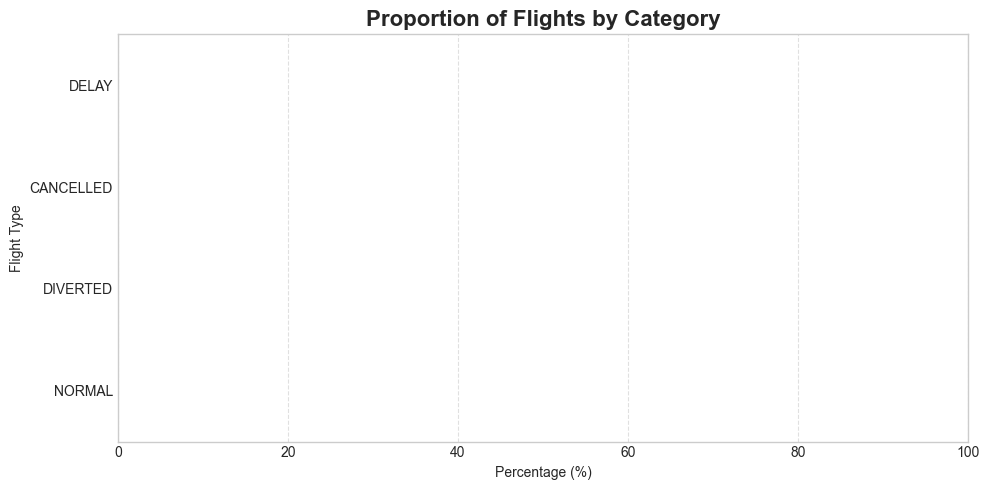

In [257]:
problem_counts = df[problematic_columns].sum()

total_flights = len(df)
total_problematic_flights = df[problematic_columns].any(axis=1).sum()
normal_flights_count = total_flights - total_problematic_flights

all_counts = problem_counts.to_dict()
all_counts["NORMAL"] = normal_flights_count
summary_df = pd.DataFrame(all_counts.items(), columns=["Problem_Type", "Count"])

summary_df["Percentage"] = (summary_df["Count"] / total_flights) * 100
summary_df.loc[summary_df['Problem_Type'] == 'DEP_DEL15', 'Problem_Type'] = 'DELAY'
summary_df_sorted = summary_df.sort_values(by="Percentage", ascending=False)

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=summary_df_sorted,
    x="Percentage",
    y="Problem_Type",
    hue="Problem_Type",
    palette="viridis",
    legend=False
)

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1, p.get_y() + p.get_height() / 2.,
            f'{width:.1f}%',
            ha="left", va="center")

plt.title("Proportion of Flights by Category", fontsize=16, fontweight="bold")
plt.xlabel("Percentage (%)")
plt.ylabel("Flight Type")
plt.xlim(0, 100)
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [258]:

# Top 10 airlines with most problems (delays, cancellations, diversions)
results_airline = []
for col in problematic_columns:
    top_prob_airlines = (
        df.groupby("AIRLINE_Description")[col].sum().nlargest(10))
    results_airline.append(top_prob_airlines.rename(col))
summary_table_airline = pd.concat(results_airline, axis=1).fillna(0).astype(int)
summary_table_airline = summary_table_airline.sort_values("DELAY", ascending=False)

summary_table_airline.head(10)

,DELAY,CANCELLED,DIVERTED
AIRLINE_Description,,,


In [259]:
# Average departure delay by airline
avg_delay_airline = df.groupby("AIRLINE_Description")["DELAY_OVERALL"].mean().reset_index()
avg_delay_airline = avg_delay_airline.sort_values(by="DELAY_OVERALL", ascending=False)

avg_delay_airline.head(5)

,AIRLINE_Description,DELAY_OVERALL


In [260]:
# Top 10 city origin with most problems (delays, cancellations, diversions)
results_city = []
for col in problematic_columns:
    top_prob_airlines = (df.groupby("ORIGIN_CITY")[col].sum().nlargest(10))
    results_city.append(top_prob_airlines.rename(col))
summary_table_city = pd.concat(results_city, axis=1).fillna(0).astype(int)
summary_table_city = summary_table_city.sort_values("DELAY", ascending=False)

summary_table_city.head(5)

,DELAY,CANCELLED,DIVERTED
ORIGIN_CITY,,,


In [261]:

# Average departure delay by airline
avg_delay_city = df.groupby("ORIGIN_CITY")["DELAY_OVERALL"].mean().reset_index()
avg_delay_city = avg_delay_city.sort_values(by="DELAY_OVERALL", ascending=False)

avg_delay_city.head(5)

,ORIGIN_CITY,DELAY_OVERALL


## 2.2. Aplicar medidas de tendência central e dispersão

In [262]:
analysis_columns = ['CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CRS_ELAPSED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'FL_DAY', 'DELAY_TOTAL', 'DELAY_OVERALL']

In [263]:
central_tendency_dic = {}

for col in analysis_columns:
    if col in df.columns:
        mean = df[col].mean()
        median = df[col].median()
        mode = df[col].mode()
        mode_val = mode.iloc[0] if not mode.empty else None
        std_dev = df[col].std()
        central_tendency_dic[col] = {
            'Mean': mean,
            'Median': median,
            'Mode': mode_val,
            'Standard Deviation': std_dev
        }

df_central_tendency_dic = pd.DataFrame(central_tendency_dic).T

df_central_tendency_dic

,Mean,Median,Mode,Standard Deviation
CRS_DEP_TIME,NaN,NaN,NaN,NaN
DEP_TIME,NaN,NaN,NaN,NaN
DEP_DELAY,NaN,NaN,NaN,NaN
TAXI_OUT,NaN,NaN,NaN,NaN
WHEELS_OFF,NaN,NaN,NaN,NaN
WHEELS_ON,NaN,NaN,NaN,NaN
TAXI_IN,NaN,NaN,NaN,NaN
CRS_ARR_TIME,NaN,NaN,NaN,NaN
ARR_TIME,NaN,NaN,NaN,NaN
ARR_DELAY,NaN,NaN,NaN,NaN


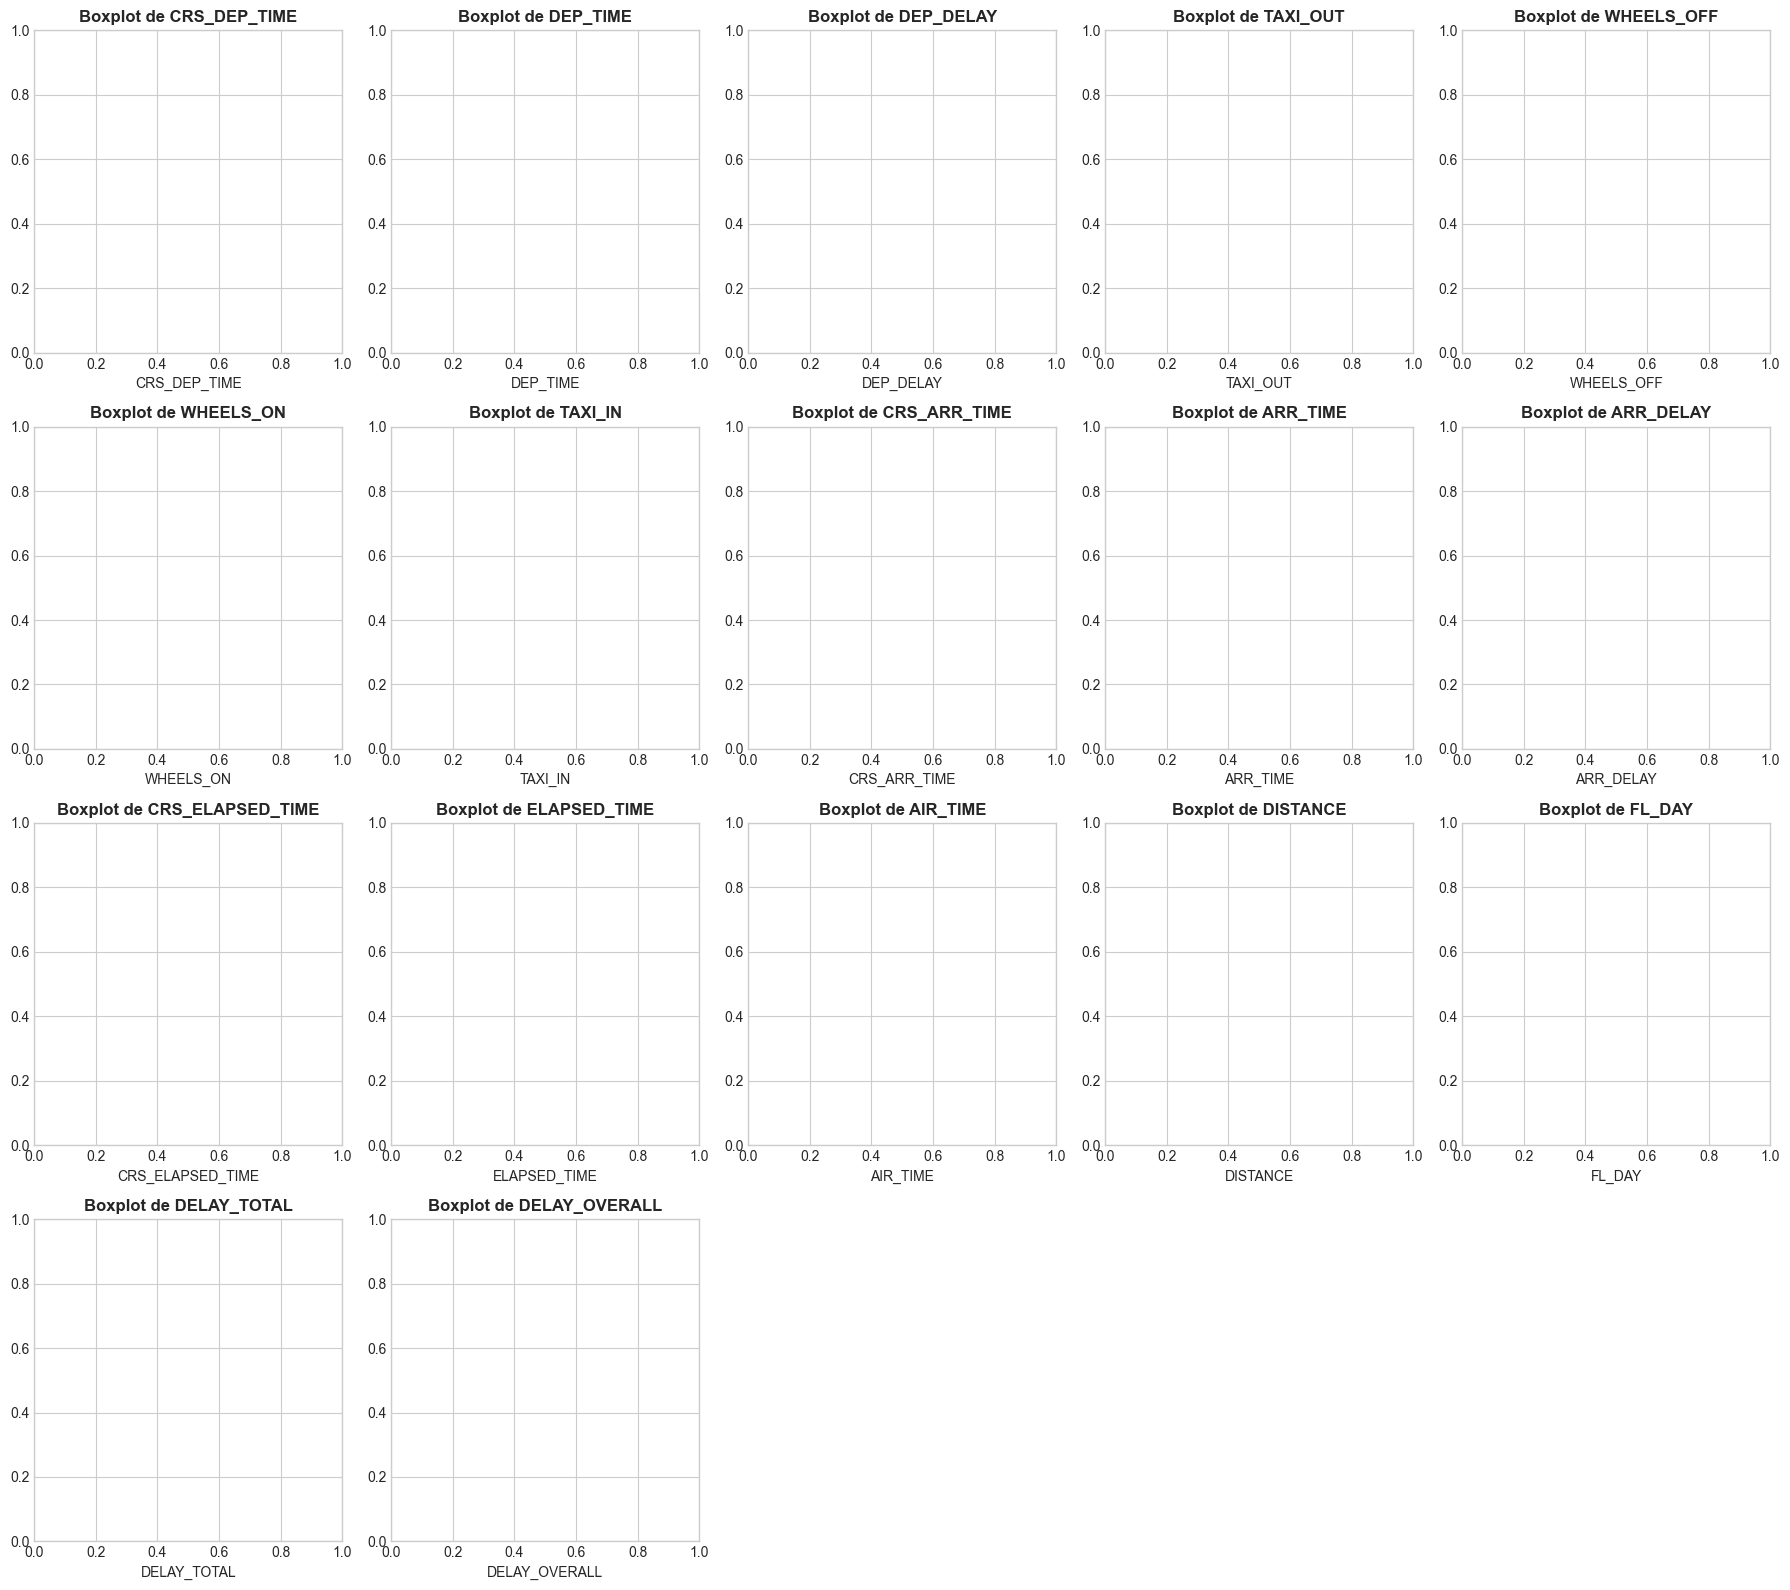

In [264]:
# Boxplots

n_cols = 5
n_rows = math.ceil(len(analysis_columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(analysis_columns):
    if col in df.columns:
        sns.boxplot(x=df[col], color="royalblue", ax=axes[i])
        axes[i].set_title(f"Boxplot de {col}", fontsize=12, fontweight="bold")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("")

# Remove eixos extras
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

2.2.1. Verificar distribuição

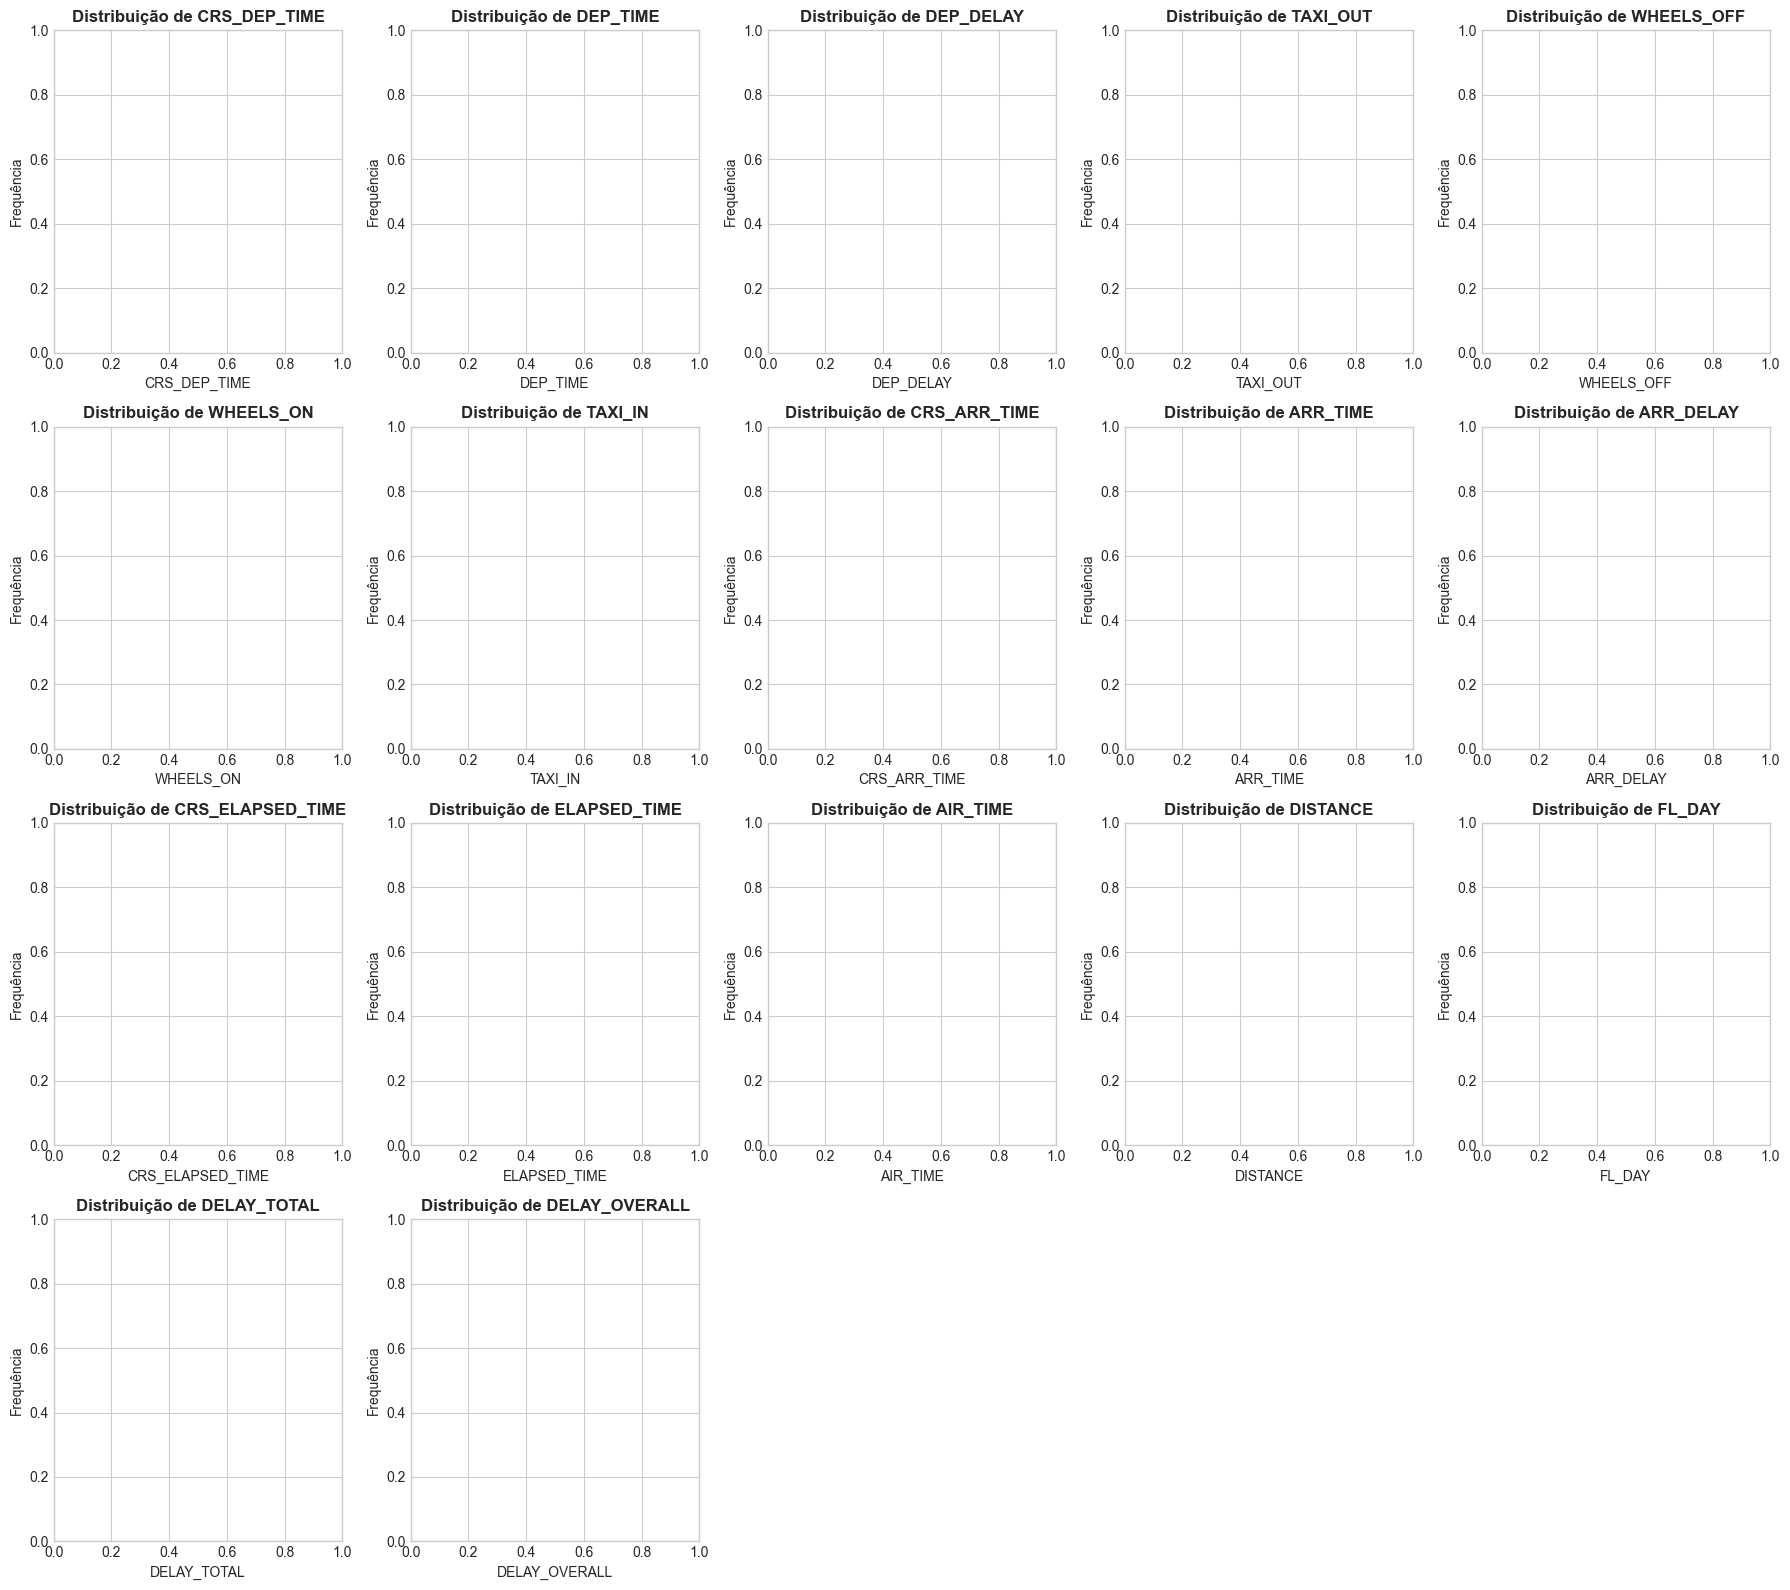

In [265]:
# Histograms

n_cols = 5
n_rows = math.ceil(len(analysis_columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(analysis_columns):
    if col in df.columns:
        sns.histplot(df[col], bins=50, kde=True, color="royalblue", ax=axes[i])
        axes[i].set_title(f"Distribuição de {col}", fontsize=12, fontweight="bold")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Frequência")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 2.3. Calcular quartis, decis ou percentis

In [266]:
# Calcule a matriz de correlação de Pearson
correlation_matrix = df[analysis_columns].corr(method='pearson')

print("--- Matriz de Correlação de Pearson ---")
# O .round(2) é para exibir os valores com duas casas decimais, o que melhora a leitura
display(correlation_matrix.round(2))

--- Matriz de Correlação de Pearson ---


,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,FL_DAY,DELAY_TOTAL,DELAY_OVERALL
CRS_DEP_TIME,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEP_TIME,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEP_DELAY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TAXI_OUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WHEELS_OFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WHEELS_ON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TAXI_IN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CRS_ARR_TIME,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ARR_TIME,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ARR_DELAY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2.4. Aplicação de Mapa de carlor - Correlação de Person

c:\Users\Notebook\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\Notebook\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


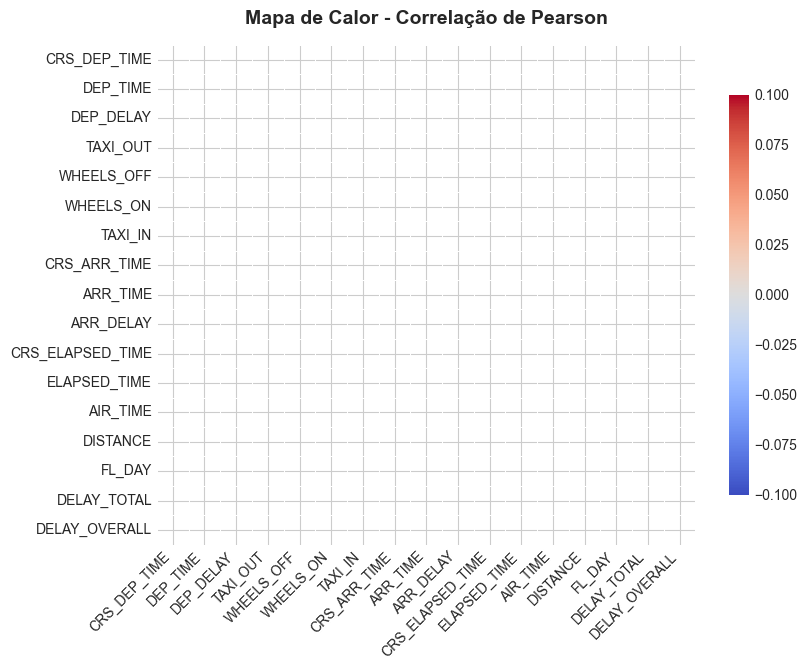

In [267]:
# Heatmap
plt.figure(figsize=(len(analysis_columns) * 0.5, len(analysis_columns) * 0.4))
correlation_matrix = df[analysis_columns].corr(method='pearson')

sns.heatmap(
    correlation_matrix.round(2),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Mapa de Calor - Correlação de Pearson", fontsize=14, fontweight="bold", pad=15)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 3. Aplicar técnica da análise

## 3.1. Aplicar Segmentação

3.1.1. Funções por plot

In [268]:
def plot_multiple_bar_metrics(df, metrics_list, group_col, title):
    """
    Plota múltiplos gráficos de barras para as métricas fornecidas, com base no modelo
    padronizado.

    Args:
        df (pd.DataFrame): O DataFrame de entrada.
        metrics_list (list): Uma lista com os nomes das colunas de métricas para plotar.
        group_col (str): O nome da coluna para agrupar.
        title (str): O título principal do gráfico.
    """
    plt.style.use('seaborn-v0_8-whitegrid')

    num_plots = len(metrics_list)
    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 7), sharey=False)

    if num_plots == 1:
        axes = [axes]

    for i, col in enumerate(metrics_list):
        grouped_data = df.groupby(group_col, observed=True)[col].mean().reset_index()

        sns.barplot(
            data=grouped_data,
            x=group_col,
            y=col,
            hue=group_col,
            palette="viridis",
            legend=False,
            ax=axes[i]
        )
        
        mean_val = grouped_data[col].mean()
        axes[i].axhline(
            mean_val,
            color="red",
            linestyle="--",
            linewidth=1.2,
            label=f"Mean: {mean_val:.2f}"
        )

        axes[i].set_title(f"{col.replace('_', ' ').title()}", fontsize=18, fontweight="bold")
        axes[i].set_xlabel(group_col.replace('_', ' ').title(), fontsize=14)
        axes[i].set_ylabel("Mean (min)" if "DELAY" in col.upper() else "Porcentagem de Voos (%)", fontsize=14)

        x_labels = grouped_data[group_col]
        axes[i].set_xticks(range(len(x_labels)))
        axes[i].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=12)

        axes[i].tick_params(axis='y', labelsize=12)
        axes[i].grid(axis="y", linestyle="--", alpha=0.6)
        axes[i].legend(fontsize=12)

    fig.suptitle(title, fontsize=20, fontweight='bold', y=1.03)
    plt.tight_layout()
    plt.show()

In [269]:
def plot_bar_mean_delay(df, group_col, title):
    """
    Plota um gráfico de barras da média de atraso para uma coluna de agrupamento específica.

    Args:
        df (pd.DataFrame): O DataFrame de entrada.
        group_col (str): A coluna para categorizar e agrupar (ex: 'AIRLINE_Description').
        title (str): O título do gráfico.
    """
    delay_by_group = df.groupby(group_col, observed=True)["DELAY_OVERALL"].mean().reset_index()

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    sns.barplot(
        data=delay_by_group,
        x=group_col,
        y="DELAY_OVERALL",
        hue=group_col,
        palette="viridis",
        legend=False
    )

    mean_val = delay_by_group["DELAY_OVERALL"].mean()
    ax.axhline(mean_val, color="red", linestyle="--", linewidth=1.2, label=f"Percentage of Flights: {mean_val:.2f} min")

    ax.set_title(title, fontsize=18, fontweight="bold")
    ax.set_xlabel(group_col.replace('_', ' ').title(), fontsize=14)
    ax.set_ylabel("Mean delay (min)", fontsize=14)

    x_labels = delay_by_group[group_col]
    ax.set_xticks(range(len(x_labels)))
    ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=12)

    ax.tick_params(axis='y', labelsize=12)
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.legend(fontsize=12)
    
    plt.tight_layout()
    plt.show()

In [270]:
def plot_line_multiple_metrics_by_category(df, metrics_list, group_col, title):
    """
    Plots multiple line graphs for the provided metrics, grouped by category.

    Args:
        df(pd.DataFrame): The input DataFrame.
        metrics_list(list): A list of the names of the metrics columns to plot.
        group_col(str): The column to categorize and group by (e.g., 'TIME_HOUR').
        title(str): The main title of the figure.
    """
    plt.style.use('seaborn-v0_8-whitegrid')

    grouped_metrics = df.groupby(group_col, observed=True)[metrics_list].mean().reset_index()

    num_plots = len(metrics_list)

    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5), sharey=False)

    if num_plots == 1:
        axes = [axes]

    for i, col in enumerate(metrics_list):
        sns.lineplot(
            data=grouped_metrics,
            x=group_col,
            y=col,
            marker="o",
            color="royalblue",
            ax=axes[i]
        )

        axes[i].fill_between(
            grouped_metrics[group_col],
            grouped_metrics[col],
            color="royalblue",
            alpha=0.2
        )

        mean_val = grouped_metrics[col].mean()
        axes[i].axhline(
            mean_val,
            color="red",
            linestyle="--",
            linewidth=1.2,
            label=f"Mean: {mean_val:.3f}"
        )

        axes[i].set_title(f"{col.replace('_', ' ').title()}", fontsize=12, fontweight="bold")
        axes[i].set_xlabel(group_col.replace('_', ' ').title())
        axes[i].set_ylabel("Percentage of Flights")
        axes[i].grid(axis="y", linestyle="--", alpha=0.6)
        axes[i].legend()

    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.03)

    plt.tight_layout()
    plt.show()

In [271]:
def plot_line_by_category(df, group_col, title):
    """
    Plots a line graph of the average lag for a specific grouping column.

    Args:
        df(pd.DataFrame): The input DataFrame.
        group_col(str): The column to categorize and group by (e.g., 'TIME_HOUR').
        title(str): The title of the graph.
    """
    delay_by_group = df.groupby(group_col, observed=True)["DELAY_OVERALL"].mean().reset_index()


    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))

    sns.lineplot(
        data=delay_by_group,
        x=group_col,
        y="DELAY_OVERALL",
        marker="o",
        color="royalblue",
        markersize=6,
        ax=ax
    )

    ax.fill_between(delay_by_group[group_col], delay_by_group["DELAY_OVERALL"], color="skyblue", alpha=0.4)

    mean_val = delay_by_group["DELAY_OVERALL"].mean()
    ax.axhline(
        mean_val,
        color="red",
        linestyle="--",
        linewidth=1.2,
        label=f"Mean: {mean_val:.2f} min"
    )

    ax.set_title(title, fontsize=18, fontweight="bold")
    ax.set_xlabel(group_col.replace('_', ' ').title(), fontsize=14)
    ax.set_ylabel("Mean delay (min)", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)

    ax.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

3.1.2. Por distnância de voo

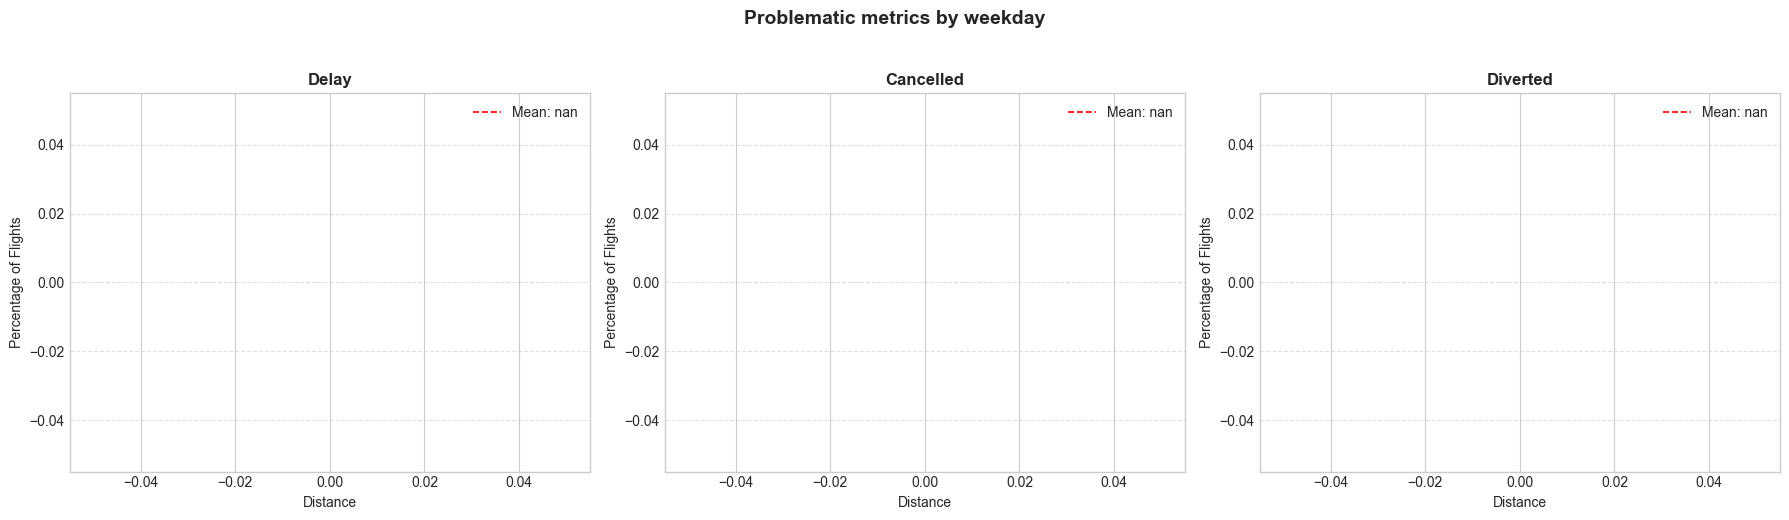

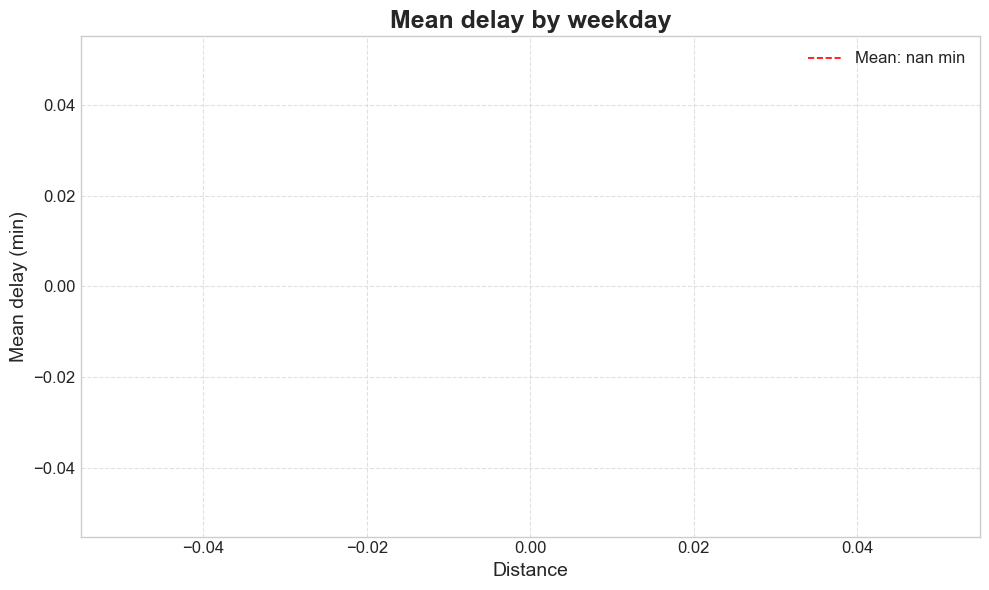

In [272]:

plot_line_multiple_metrics_by_category(df, problematic_columns, "DISTANCE", "Problematic metrics by weekday")
plot_line_by_category(df, "DISTANCE", "Mean delay by weekday")

3.1.3. Por período do dia 

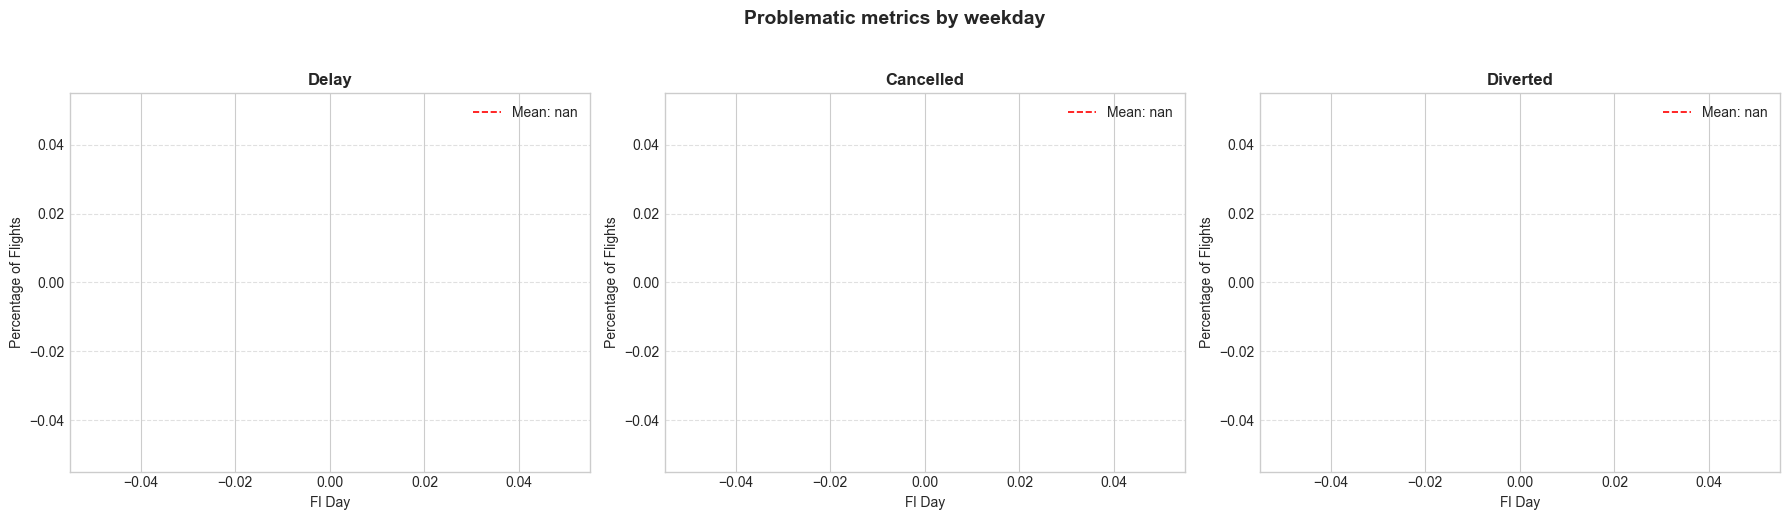

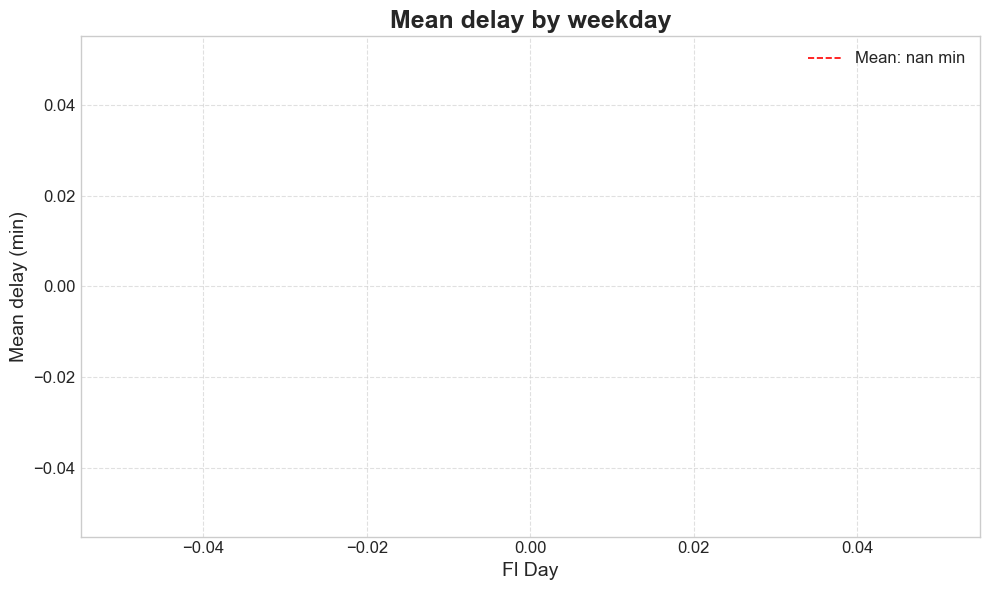

In [273]:

plot_line_multiple_metrics_by_category(df, problematic_columns, "FL_DAY", "Problematic metrics by weekday")
plot_line_by_category(df, "FL_DAY", "Mean delay by weekday")

3.1.4. Por dia da semana

In [274]:
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df["DAY_OF_WEEK"] = pd.Categorical(df["DAY_OF_WEEK"], categories=weekday_order, ordered=True)

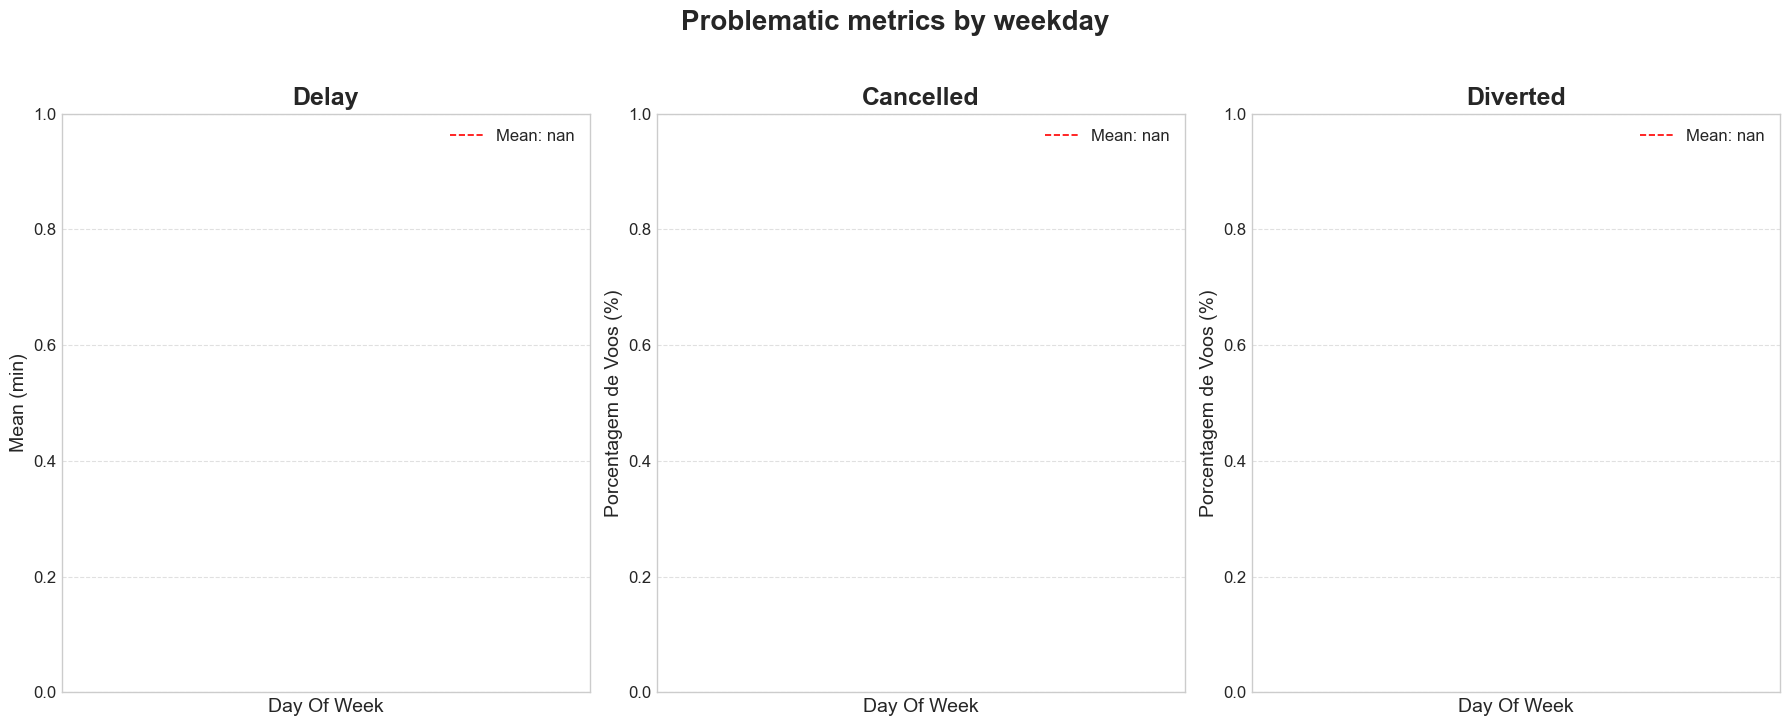

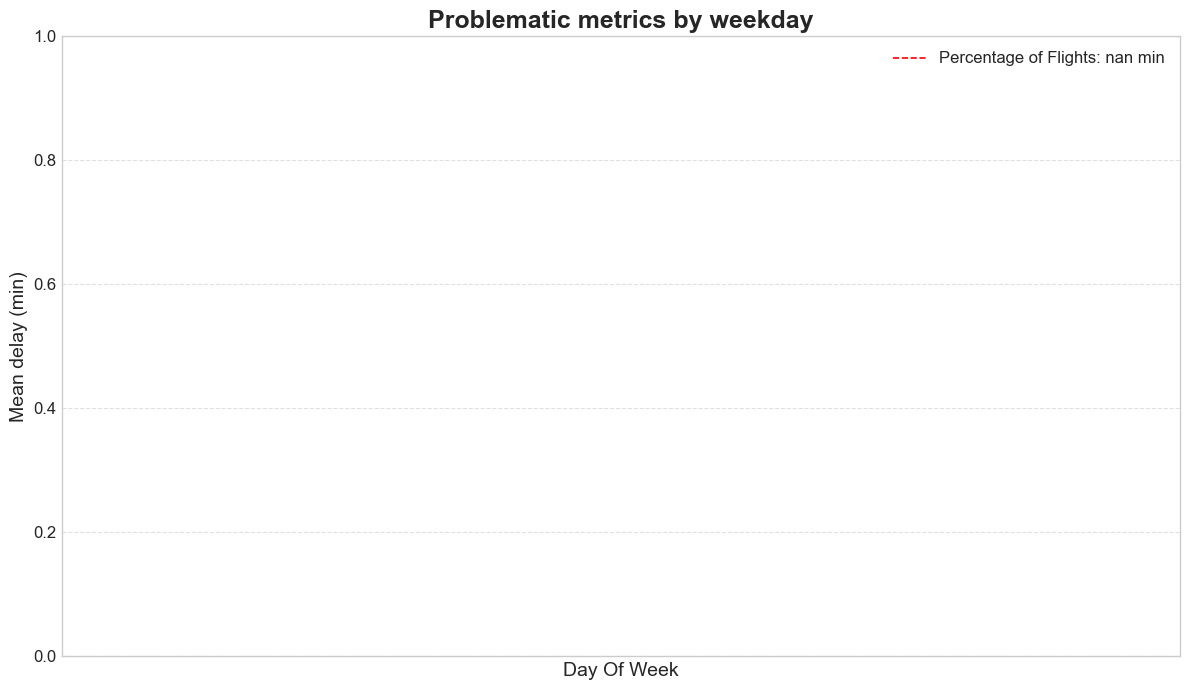

In [275]:

plot_multiple_bar_metrics(df, problematic_columns, "DAY_OF_WEEK", "Problematic metrics by weekday")
plot_bar_mean_delay(df, "DAY_OF_WEEK", "Problematic metrics by weekday")

In [276]:
period_day_order = ["Early Morning", "Morning", "Afternoon", "Evening"]
df["TIME_PERIOD"] = pd.Categorical(df["TIME_PERIOD"], categories=period_day_order, ordered=True)

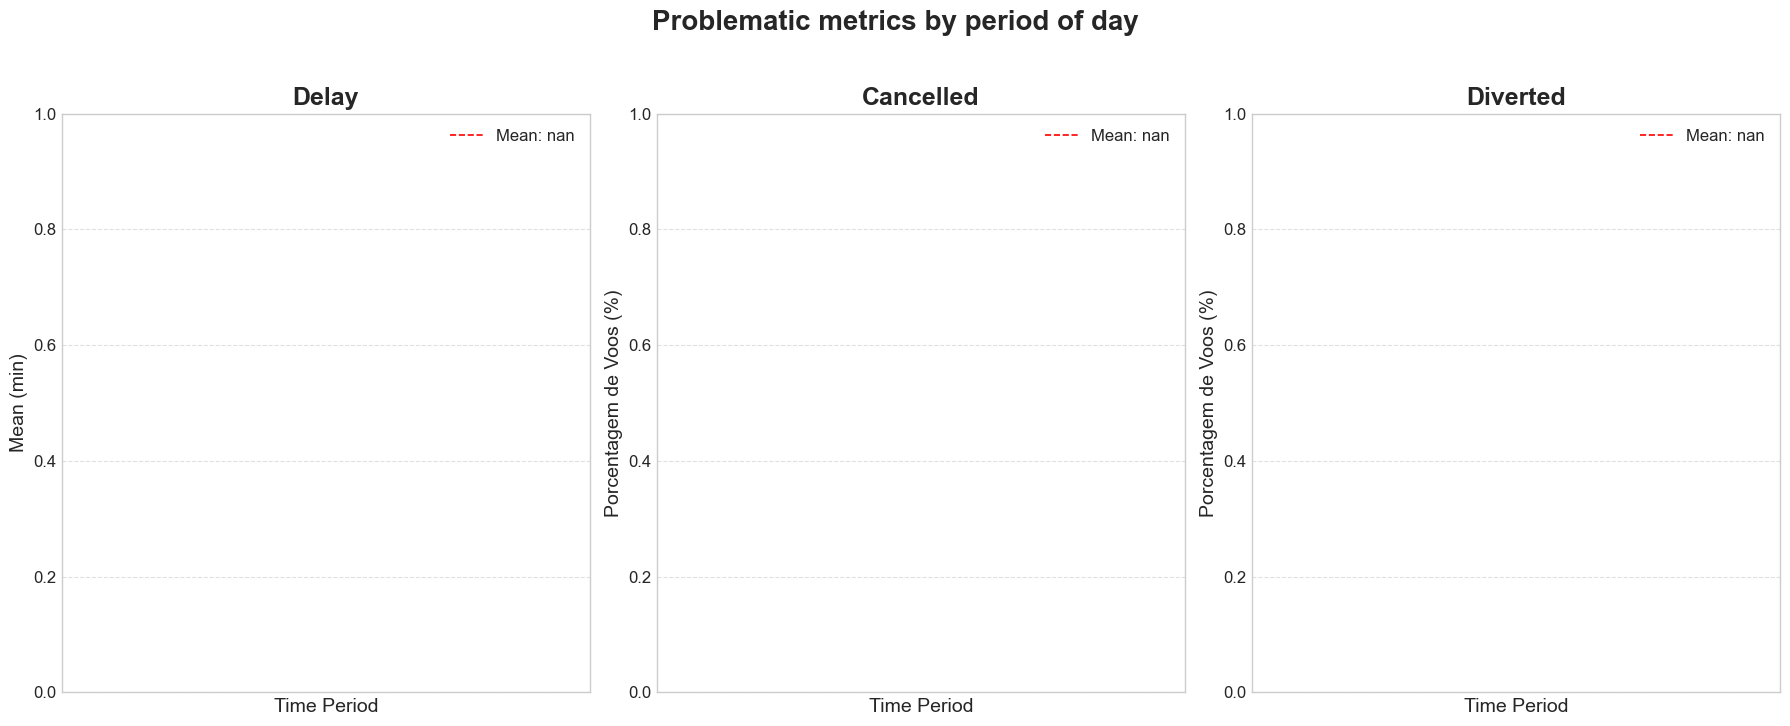

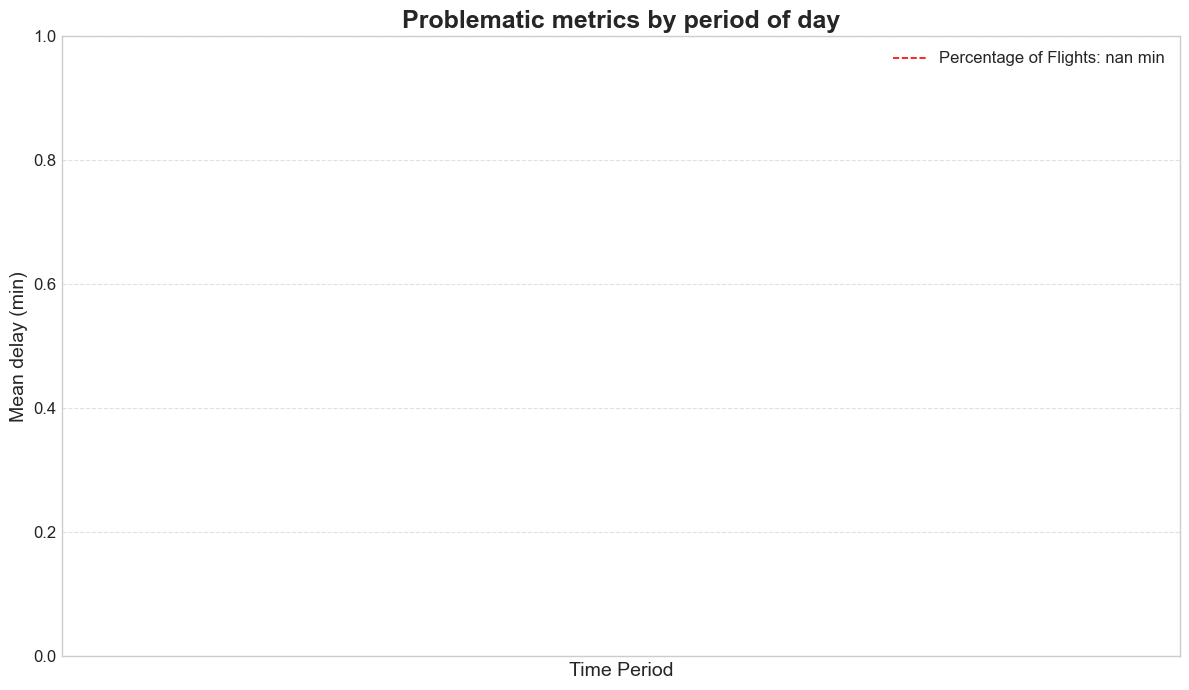

In [277]:
plot_multiple_bar_metrics(df, problematic_columns, "TIME_PERIOD", "Problematic metrics by period of day")
plot_bar_mean_delay(df, "TIME_PERIOD", "Problematic metrics by period of day")

3.1.5. Por hora do dia

In [278]:
df['TIME_HOUR'] = pd.cut(df['DEP_TIME'],
                         bins=range(0, 2401, 100),
                         labels=range(24),
                         right=False)

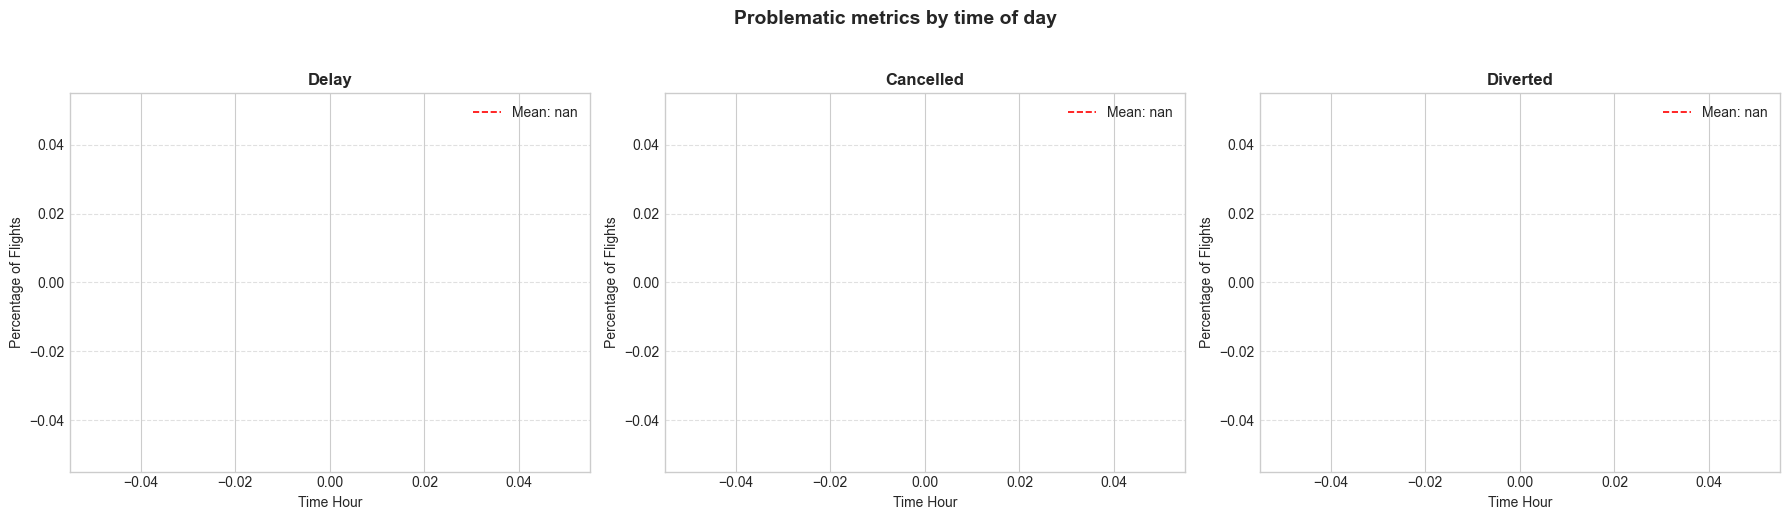

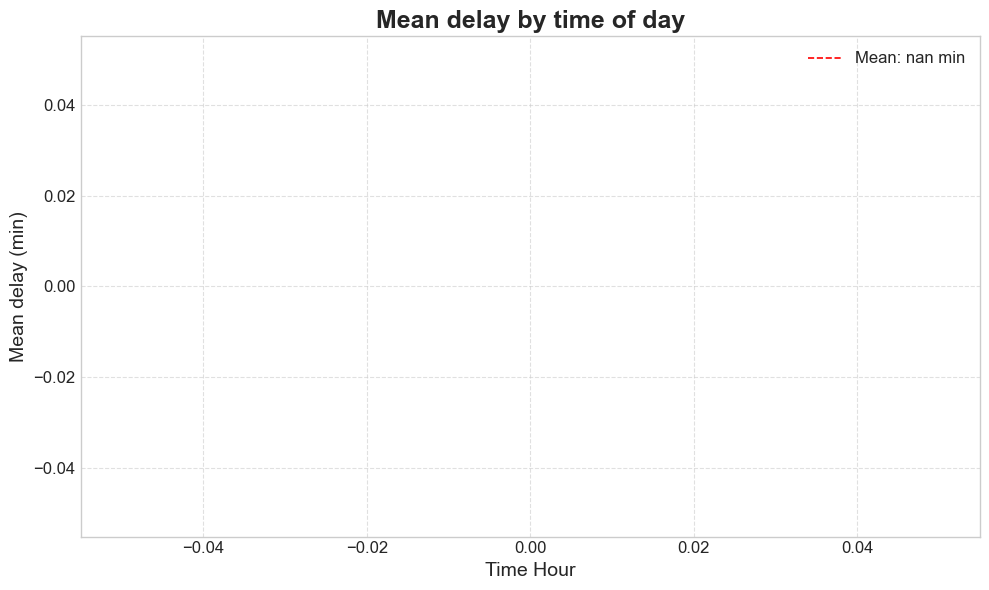

In [279]:
plot_line_multiple_metrics_by_category(df, problematic_columns, "TIME_HOUR", "Problematic metrics by time of day")
plot_line_by_category(df, 'TIME_HOUR', "Mean delay by time of day")

## 3.2. Validar Hipóteses

3.2.1. Funções para teste

In [280]:

def perform_t_test(group1_data, group2_data, alpha=0.05):
    """
    Performs an independent samples t-test.

    Args:
        group1_data (pd.Series): Data for the first group.
        group2_data (pd.Series): Data for the second group.
        alpha (float): Significance level.

    Returns:
        tuple: (t_statistic, p_value, significant_difference)
    """
    t_statistic, p_value = ttest_ind(group1_data.dropna(), group2_data.dropna(), equal_var=False) # Welch's t-test
    significant_difference = p_value < alpha
    return t_statistic, p_value, significant_difference

In [281]:
def perform_chi2_test(contingency_table, alpha=0.05):
    """
    Performs a Chi-squared test of independence.

    Args:
        contingency_table (pd.DataFrame): Contingency table.
        alpha (float): Significance level.

    Returns:
        tuple: (chi2_statistic, p_value, significant_association)
    """
    chi2_statistic, p_value, _, _ = chi2_contingency(contingency_table)
    significant_association = p_value < alpha
    return chi2_statistic, p_value, significant_association

In [282]:
def validate_mean_hypothesis(df, group_col, target_col, focus_values, h1_description, alpha=0.05):
    """
    Validates a hypothesis about the mean of a target variable between a focus group and others.

    Args:
        df (pd.DataFrame): The input DataFrame.
        group_col (str): The column used for grouping (e.g., 'AIRLINE_TYPE', 'ORIGIN_CITY').
        target_col (str): The numerical column for which the mean is compared (e.g., 'DEP_DELAY').
        focus_values (list): A list of values defining the focus group.
        h1_description (str): Description of the alternative hypothesis.
        alpha (float): Significance level.
    """
    print(f"\n🔴 Hipótese: {h1_description}")

    df_copy = df.copy()
    df_copy['is_focus_group'] = df_copy[group_col].isin(focus_values)

    group_focus = df_copy[df_copy['is_focus_group'] == True][target_col]
    group_others = df_copy[df_copy['is_focus_group'] == False][target_col]

    if group_focus.empty or group_others.empty:
        print("⚠️ Não há dados suficientes para comparar os grupos.")
        return

    t_statistic, p_value, significant_difference = perform_t_test(group_focus, group_others, alpha)

    print(f"T-statistic: {t_statistic:.4f} | p-value: {p_value:.4f}")

    if significant_difference:
        print(f"✅ Rejeita H0 (diferença significativa ao nível de {alpha*100:.0f}%)")
        mean_focus = group_focus.mean()
        mean_others = group_others.mean()
        if mean_focus > mean_others:
            print(f"➡️ Média do grupo de foco ({mean_focus:.2f}) é maior que a média dos outros ({mean_others:.2f}).")
        else:
            print(f"➡️ Média do grupo de foco ({mean_focus:.2f}) é menor que a média dos outros ({mean_others:.2f}).")
    else:
        print(f"⚠️ Não rejeita H0 (não há diferença significativa ao nível de {alpha*100:.0f}%)")

In [283]:
def validate_binary_hypothesis(df, group_col, binary_target_col, focus_values, h1_description, alpha=0.05):
    """
    Validates a hypothesis about the proportion of a binary target variable between a focus group and others.

    Args:
        df (pd.DataFrame): The input DataFrame.
        group_col (str): The column used for grouping (e.g., 'AIRLINE_TYPE', 'ORIGIN_CITY').
        binary_target_col (str): The binary column (0/1 or True/False) for which proportions are compared.
        focus_values (list): A list of values defining the focus group.
        h1_description (str): Description of the alternative hypothesis.
        alpha (float): Significance level.
    """
    print(f"\n🔴 Hipótese: {h1_description}")

    df_copy = df.copy()
    df_copy['is_focus_group'] = df_copy[group_col].isin(focus_values)

    contingency_table = pd.crosstab(df_copy['is_focus_group'], df_copy[binary_target_col])

    if contingency_table.empty or contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
        print("⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado.")
        return

    chi2_statistic, p_value, significant_association = perform_chi2_test(contingency_table, alpha)

    proportions = df_copy.groupby('is_focus_group')[binary_target_col].mean()
    print("📊 Proporções por grupo:")
    print(proportions.round(3))
    print(f"Qui-quadrado={chi2_statistic:.4f} | p-value={p_value:.4f}")

    if significant_association:
        print(f"✅ Rejeita H0: existe associação significativa entre os grupos e {binary_target_col.lower()} (nível de {alpha*100:.0f}%). ")
        prop_focus = proportions.get(True, 0)
        prop_others = proportions.get(False, 0)
        if prop_focus > prop_others:
            print(f"➡️ O grupo de foco tem maior proporção de {binary_target_col.lower()} ({prop_focus:.3f}) do que os outros ({prop_others:.3f}).")
        else:
            print(f"➡️ O grupo de foco tem menor proporção de {binary_target_col.lower()} ({prop_focus:.3f}) do que os outros ({prop_others:.3f}).")
    else:
        print(f"⚠️ Não rejeita H0: não há associação significativa entre os grupos e {binary_target_col.lower()} (nível de {alpha*100:.0f}%).")

In [284]:
def validate_categorical_groups_mean(df, group_col, target_col, h1_description, alpha=0.05):
    """
    Validates a hypothesis about the mean of a target variable across multiple categorical groups using ANOVA.

    Args:
        df (pd.DataFrame): The input DataFrame.
        group_col (str): The column used for grouping.
        target_col (str): The numerical column for which the mean is compared.
        h1_description (str): Description of the alternative hypothesis.
        alpha (float): Significance level.
    """
    print(f"\n🔴 Hipótese: {h1_description}")

    groups = [df[target_col].dropna() for name, df in df.groupby(group_col, observed=True)]

    if len(groups) < 2:
        print("⚠️ Não há grupos suficientes para realizar o teste ANOVA.")
        return

    f_statistic, p_value = f_oneway(*groups)
    significant_difference = p_value < alpha

    print(f"F-statistic: {f_statistic:.4f} | p-value: {p_value:.4f}")

    if significant_difference:
        print(f"✅ Rejeita H0 (diferença significativa entre as médias dos grupos ao nível de {alpha*100:.0f}%).")
    else:
        print(f"⚠️ Não rejeita H0 (não há diferença significativa entre as médias dos grupos ao nível de {alpha*100:.0f}%).")

In [285]:
def validate_categorical_groups_binary(df, group_col, binary_target_col, h1_description, alpha=0.05):
    """
    Validates a hypothesis about the proportion of a binary target variable across multiple categorical groups using Chi-squared.

    Args:
        df (pd.DataFrame): The input DataFrame.
        group_col (str): The column used for grouping.
        binary_target_col (str): The binary column (0/1 or True/False) for which proportions are compared.
        h1_description (str): Description of the alternative hypothesis.
        alpha (float): Significance level.
    """
    print(f"\n🔴 Hipótese: {h1_description}")

    contingency_table = pd.crosstab(df[group_col], df[binary_target_col])

    if contingency_table.empty or contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
        print("⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado.")
        return

    chi2_statistic, p_value, significant_association = perform_chi2_test(contingency_table, alpha)

    proportions = df.groupby(group_col, observed=True)[binary_target_col].mean()
    print("📊 Proporções por grupo:")
    print(proportions.round(3))
    print(f"Qui-quadrado={chi2_statistic:.4f} | p-value: {p_value:.4f}")

    if significant_association:
        print(f"✅ Rejeita H0: existe associação significativa entre os grupos e {binary_target_col.lower()} (nível de {alpha*100:.0f}%). ")
    else:
        print(f"⚠️ Não rejeita H0: não há associação significativa entre os grupos e {binary_target_col.lower()} (nível de {alpha*100:.0f}%).")

3.2.2. Companhia Aéreas

In [286]:
low_cost = ["FRONTIER AIRLINES INC.", "SPIRIT AIR LINES", "ALLEGIANT AIR", "JETBLUE AIRWAYS"]

df["AIRLINE_TYPE"] = df["AIRLINE_Description"].apply(lambda x: "Low-cost" if x in low_cost else "Legacy")

```Companhias low-cost atrasam mais que tradicionais```

In [287]:
validate_mean_hypothesis(
    df=df,
    group_col="AIRLINE_TYPE",
    target_col="DEP_DELAY",
    focus_values=["Low-cost"],
    h1_description="Companhias low-cost atrasam mais que tradicionais (média de atraso)"
)


🔴 Hipótese: Companhias low-cost atrasam mais que tradicionais (média de atraso)
⚠️ Não há dados suficientes para comparar os grupos.


```Companhias low-cost têm mais cancelamentos, atrasos ou desvios que tradicionais```

In [288]:
for col in problematic_columns:
        validate_binary_hypothesis(
            df=df,
            group_col="AIRLINE_TYPE",
            binary_target_col=col,
            focus_values=["Low-cost"],
            h1_description=f"Companhias low-cost têm mais {col} que tradicionais (proporção)"
        )


🔴 Hipótese: Companhias low-cost têm mais DELAY que tradicionais (proporção)
⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado.

🔴 Hipótese: Companhias low-cost têm mais CANCELLED que tradicionais (proporção)
⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado.

🔴 Hipótese: Companhias low-cost têm mais DIVERTED que tradicionais (proporção)
⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado.


3.2.3. Cidade de Origem

In [289]:
cities_focus = ["CHICAGO, IL", "DENVER, CO", "ATLANTA, GA", "DALLAS/FORT WORTH, TX"]

```As cidades CHICAGO, DENVER, ATLANTA e DALLAS/FORT WORTH têm taxas de atrasos diferentes das demais```

In [290]:
validate_mean_hypothesis(
    df=df,
    group_col="ORIGIN_CITY",
    target_col="DEP_DELAY",
    focus_values=cities_focus,
    h1_description="Cidades de foco têm atraso médio de partida diferente das demais"
)


🔴 Hipótese: Cidades de foco têm atraso médio de partida diferente das demais
⚠️ Não há dados suficientes para comparar os grupos.


```As cidades CHICAGO, DENVER, ATLANTA e DALLAS/FORT WORTH têm mais cancelamentos, atrasos ou desvios que tradicionais```

In [291]:
for problem_col in problematic_columns:
    validate_binary_hypothesis(
        df=df,
        group_col="ORIGIN_CITY",
        binary_target_col=problem_col,
        focus_values=cities_focus,
        h1_description=f"Cidades de foco têm mais {problem_col} que as demais (proporção)"
    )



🔴 Hipótese: Cidades de foco têm mais DELAY que as demais (proporção)
⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado.

🔴 Hipótese: Cidades de foco têm mais CANCELLED que as demais (proporção)
⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado.

🔴 Hipótese: Cidades de foco têm mais DIVERTED que as demais (proporção)
⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado.


#### 3.2.4. Distância

In [292]:
df["DISTANCE_GROUP"] = df["DISTANCE"].apply(
    lambda x: "Short (<1000km)" if x < 1000 else ("Long (>3000km)" if x > 3000 else "Medium")
)

```Voos curtos (<1000km) têm mais atrasos que longos (>3000km)```

In [293]:
validate_mean_hypothesis(
    df=df,
    group_col="DISTANCE_GROUP",
    target_col="DEP_DELAY",
    focus_values=["Short (<1000km)"],
    h1_description="Voos curtos (<1000km) têm mais atrasos que voos longos (>3000km) (média de atraso)"
)


🔴 Hipótese: Voos curtos (<1000km) têm mais atrasos que voos longos (>3000km) (média de atraso)
⚠️ Não há dados suficientes para comparar os grupos.


```Voos curtos (<300km) têm mais cancelamentos, atrasos ou desvios do que voos longos (>1000km)```

In [294]:
for problem_col in problematic_columns:
    validate_binary_hypothesis(
        df=df,
        group_col="DISTANCE_GROUP",
        binary_target_col=problem_col,
        focus_values=["Short (<1000km)"],
        h1_description=f"Voos curtos (<1000km) têm mais {problem_col} que voos longos (>3000km) (proporção)"
    )


🔴 Hipótese: Voos curtos (<1000km) têm mais DELAY que voos longos (>3000km) (proporção)
⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado.

🔴 Hipótese: Voos curtos (<1000km) têm mais CANCELLED que voos longos (>3000km) (proporção)
⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado.

🔴 Hipótese: Voos curtos (<1000km) têm mais DIVERTED que voos longos (>3000km) (proporção)
⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado.


#### 3.2.5. Período do mês

In [295]:
df["MONTH_PERIOD"] = df["FL_DAY"].apply(
    lambda x: "1-5" if 1 <= x <= 5 else ("10-12" if 10 <= x <= 12 else "Others")
)

```Dias 1–5 e 10–12 concentram maiores atrasos do que os demais dias```

In [296]:
validate_categorical_groups_mean(
    df=df,
    group_col="MONTH_PERIOD",
    target_col="DEP_DELAY",
    h1_description="Dias 1-5 e 10-12 concentram maiores atrasos do que os demais dias (média de atraso)"
)


🔴 Hipótese: Dias 1-5 e 10-12 concentram maiores atrasos do que os demais dias (média de atraso)
⚠️ Não há grupos suficientes para realizar o teste ANOVA.


```Dias 1–5 e 10–12 têm mais cancelamentos, atrasos ou desvios do que os demais dias```

In [297]:
for problem_col in problematic_columns:
    validate_categorical_groups_binary(
        df=df,
        group_col="MONTH_PERIOD",
        binary_target_col=problem_col,
        h1_description=f"Dias 1-5 e 10-12 concentram mais {problem_col} do que os demais dias (proporção)"
    )


🔴 Hipótese: Dias 1-5 e 10-12 concentram mais DELAY do que os demais dias (proporção)
⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado.

🔴 Hipótese: Dias 1-5 e 10-12 concentram mais CANCELLED do que os demais dias (proporção)
⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado.

🔴 Hipótese: Dias 1-5 e 10-12 concentram mais DIVERTED do que os demais dias (proporção)
⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado.


#### 3.2.6. Dia da semana

```Quartas-feiras têm mais atraso médio que outros dias```

In [298]:
validate_categorical_groups_mean(
    df=df,
    group_col="DAY_OF_WEEK",
    target_col="DEP_DELAY",
    h1_description="Quartas-feiras têm mais atraso médio que outros dias (média de atraso)"
)


🔴 Hipótese: Quartas-feiras têm mais atraso médio que outros dias (média de atraso)
⚠️ Não há grupos suficientes para realizar o teste ANOVA.


In [299]:
for problem_col in problematic_columns:
    validate_categorical_groups_binary(
        df=df,
        group_col="DAY_OF_WEEK",
        binary_target_col=problem_col,
        h1_description=f"Quartas-feiras têm mais {problem_col} que outros dias (proporção)"
    )


🔴 Hipótese: Quartas-feiras têm mais DELAY que outros dias (proporção)
⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado.

🔴 Hipótese: Quartas-feiras têm mais CANCELLED que outros dias (proporção)
⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado.

🔴 Hipótese: Quartas-feiras têm mais DIVERTED que outros dias (proporção)
⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado.


#### 3.2.7. Hora do dia

```Voos noturnos (após 18h) têm mais atraso que voos diurnos```

In [300]:
validate_categorical_groups_mean(
    df=df,
    group_col="TIME_PERIOD",
    target_col="DEP_DELAY",
    h1_description="Voos noturnos (após 18h) têm mais atraso que voos diurnos (média de atraso)"
)


🔴 Hipótese: Voos noturnos (após 18h) têm mais atraso que voos diurnos (média de atraso)
⚠️ Não há grupos suficientes para realizar o teste ANOVA.


In [301]:
for problem_col in problematic_columns:
    validate_categorical_groups_binary(
        df=df,
        group_col="TIME_PERIOD",
        binary_target_col=problem_col,
        h1_description=f"Voos noturnos (após 18h) têm mais {problem_col} que voos diurnos (proporção)"
    )


🔴 Hipótese: Voos noturnos (após 18h) têm mais DELAY que voos diurnos (proporção)
⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado.

🔴 Hipótese: Voos noturnos (após 18h) têm mais CANCELLED que voos diurnos (proporção)
⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado.

🔴 Hipótese: Voos noturnos (após 18h) têm mais DIVERTED que voos diurnos (proporção)
⚠️ Tabela de contingência inválida ou com dados insuficientes para o teste Qui-quadrado.


## 3.3. Calcular risco relativo